Перший погляд на дані

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import random

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from ukrainian_stemmer import UkrainianStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline

from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers, dict_to_models
from sklearn.svm import LinearSVC
from sklearn.decomposition import KernelPCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
print ('Типи земельних ділянок:')
land_types

Типи земельних ділянок:


{1: 'ОЖБ',
 2: 'ОСГ',
 3: 'Cадова',
 4: 'Комерційна',
 5: 'Багатоповерхова',
 6: 'Товарна',
 7: 'ОЖБ та ОСГ'}

In [3]:
print ('Забудованість:')
built_up

Забудованість:


{0: 'Не забудована', 1: 'Забудована'}

In [4]:
print ('Кількість помічених оглошень: {} екземплярів'.format(land_data.shape[0]))
print ('Перших 10 оголошень:')
land_data.head(10)

Кількість помічених оглошень: 4256 екземплярів
Перших 10 оголошень:


typ_diljanky  \
0  комерційного                   
1  під забудову                   
2  садівництво                    
3  сільськогосподарського         
4                                 
5  під забудову                   
6  під забудову                   
7                                 
8                                 
9  ділянка під житлову забудову   

                                                                                                                                                                                  ciljove_pryznach_zgidno_pkku  \
0                                                                                                                                                                                                                
1                                                                                                                                                                                                                
2                                                                                                                                                                                                                
3                                                                                                                                                                                                                
4                                                                                                                                                                                                                
5                                                                                                                                                                                                                
6                                                                                                                                                                                                                
7                                                                                                                                                                                                                
8  для будівництва і обслуговування житлового будинку господарських будівель і споруд присадибна ділянка для будівництва і обслуговування житлового будинку господарських будівель і споруд присадибна ділянка   
9  для ведення особистого селянського господарства для ведення особистого селянського господарства для ведення особистого селянського господарства                                                               

                                                                                                                                                                                                                                         opys  \
0                                                                                                                                                                                                                                               
1                                                                                                                                                                                                                                               
2                                                                                                                                                                                                                                               
3                                                                                                                                                                                                                                               
4  земельних ділянок с пустомитівський р н км від львова є земельна ділянка сот приватизованої є старенький будиночок

Розподіл вибірки за типами земельних ділянок

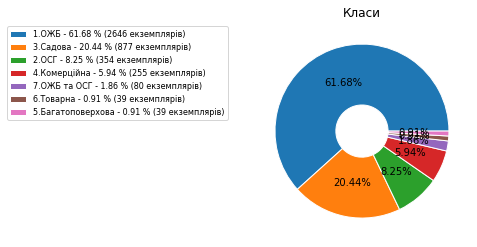

In [37]:
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)


Розподіл вибірки за забудованістю земельних ділянок

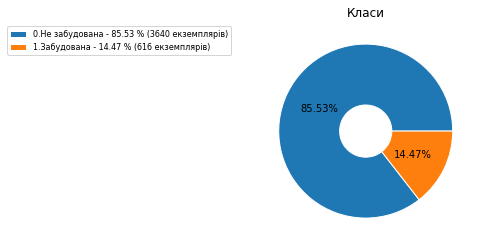

In [8]:
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

Токенізатор та функція ngrams_info

1 - grams
ua_stemmer: False
Кількість символів:  1100031
Кількість токенів:  151318
Кількість унікальних токенів:  10260
Найбільш уживані токени:  [(('ділянка',), 4163), (('під',), 3472), (('і',), 3245), (('для',), 3030), (('на',), 2531), (('в',), 2458), (('забудову',), 2158), (('ділянки',), 2032), (('будинку',), 1861), (('житлового',), 1644), (('поруч',), 1620), (('обслуговування',), 1614), (('будівництва',), 1605), (('та',), 1580), (('м',), 1532), (('є',), 1406), (('с',), 1397), (('від',), 1362), (('до',), 1328), (('комунікації',), 1309)]


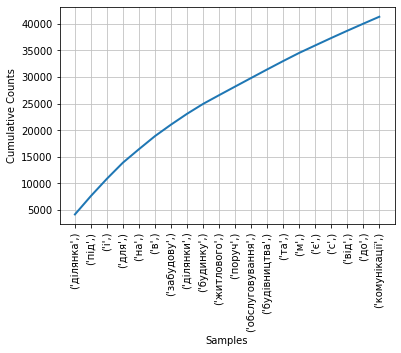

1 - grams
ua_stemmer: True
Кількість символів:  1100031
Кількість токенів:  151318
Кількість унікальних токенів:  6638
Найбільш уживані токени:  [(('ділянк',), 6916), (('під',), 3472), (('і',), 3248), (('для',), 3032), (('будівництв',), 2584), (('на',), 2532), (('в',), 2458), (('будинк',), 2336), (('забудов',), 2310), (('земельн',), 2205), (('житлов',), 2034), (('поруч',), 1620), (('обслуговуванн',), 1614), (('та',), 1580), (('м',), 1532), (('комунікаці',), 1428), (('сот',), 1416), (('є',), 1406), (('с',), 1397), (('від',), 1362)]


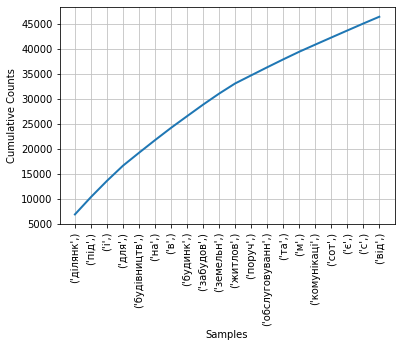

3 - grams
ua_stemmer: False
Кількість символів:  1100031
Кількість токенів:  151316
Кількість унікальних токенів:  74003
Найбільш уживані токени:  [(('обслуговування', 'житлового', 'будинку'), 1443), (('і', 'обслуговування', 'житлового'), 1233), (('будівництва', 'і', 'обслуговування'), 1205), (('для', 'будівництва', 'і'), 1202), (('будівель', 'і', 'споруд'), 1185), (('будинку', 'господарських', 'будівель'), 1183), (('господарських', 'будівель', 'і'), 1174), (('житлового', 'будинку', 'господарських'), 1167), (('споруд', 'присадибна', 'ділянка'), 1079), (('і', 'споруд', 'присадибна'), 1075), (('продаж', 'земельної', 'ділянки'), 396), (('продається', 'земельна', 'ділянка'), 372), (('ведення', 'особистого', 'селянського'), 329), (('особистого', 'селянського', 'господарства'), 324), (('для', 'ведення', 'особистого'), 310), (('під', 'забудову', 'продаж'), 296), (('для', 'індивідуального', 'садівництва'), 281), (('під', 'забудову', 'продається'), 219), (('під', 'забудову', 'ділянка'), 210), (

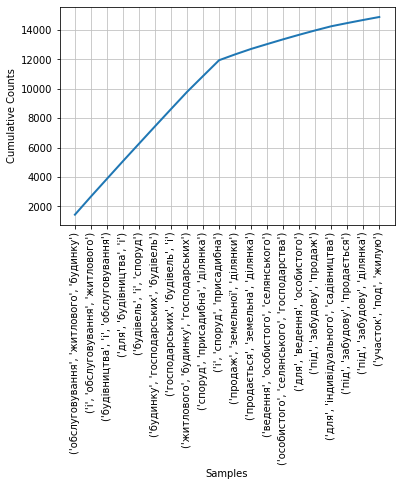

3 - grams
ua_stemmer: True
Кількість символів:  1100031
Кількість токенів:  151316
Кількість унікальних токенів:  70599
Найбільш уживані токени:  [(('обслуговуванн', 'житлов', 'будинк'), 1447), (('будівництв', 'і', 'обслуговуванн'), 1278), (('і', 'обслуговуванн', 'житлов'), 1240), (('для', 'будівництв', 'і'), 1205), (('будинк', 'господарськ', 'будівел'), 1186), (('будівел', 'і', 'споруд'), 1185), (('господарськ', 'будівел', 'і'), 1174), (('житлов', 'будинк', 'господарськ'), 1167), (('споруд', 'присадибн', 'ділянк'), 1079), (('і', 'споруд', 'присадибн'), 1075), (('продаж', 'земельн', 'ділянк'), 485), (('продаєт', 'земельн', 'ділянк'), 374), (('веденн', 'особист', 'селянськ'), 329), (('особист', 'селянськ', 'господарств'), 326), (('для', 'веденн', 'особист'), 310), (('земельн', 'ділянк', 'в'), 300), (('під', 'забудов', 'продаж'), 300), (('для', 'індивідуальн', 'садівництв'), 281), (('земельн', 'ділянк', 'під'), 260), (('будівництв', 'та', 'обслуговуванн'), 258)]


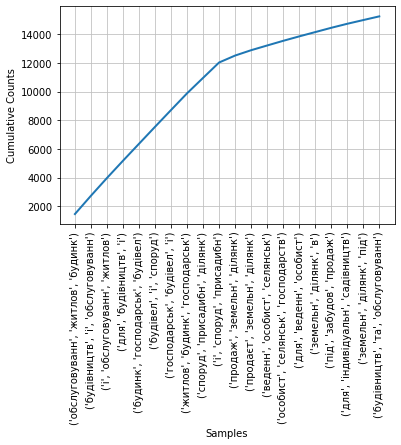

In [10]:
def ua_tokenizer(text,ua_stemmer=True,stop_words=[]):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    ua_stemmer -- if True use UkrainianStemmer for stemming words (default True)
    stop_words -- list of stop words (default [])
        
    """
    tokenized_list=[]
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    for word in nltk.word_tokenize(text): 
        if word.isalpha():
            word=word.lower() 
            if ua_stemmer is True:      
                word=UkrainianStemmer(word).stem_word()
            if word not in stop_words:
                tokenized_list.append(word) 
    return tokenized_list



def ngrams_info(series,n=1,most_common=20,ua_stemmer=True,stop_words=[]):
    """ ngrams_info - Show detailed information about string pandas.Series column. 
    
    Keyword arguments:
    series -- pandas.Series object
    most_common -- show most common words(default 50)
    ua_stemmer -- if True use UkrainianStemmer for stemming words (default True)
    stop_words -- list of stop words (default [])
        
    """
    print (n,'- grams')
    print ('ua_stemmer:',ua_stemmer)
    words=series.str.cat(sep=' ')
    print ('Кількість символів: ',len(words))
    words=nltk.ngrams(ua_tokenizer(words,ua_stemmer=ua_stemmer,stop_words=stop_words),n)
    words=nltk.FreqDist(words)
    print ('Кількість токенів: ',words.N())
    print ('Кількість унікальних токенів: ',words.B())
    print ('Найбільш уживані токени: ',words.most_common(most_common))
    words.plot (most_common, cumulative = True)
for n in (1,3):    
    ngrams_info(land_data['text'],ua_stemmer=False,n=n)
    ngrams_info(land_data['text'],ua_stemmer=True,n=n)
    


Реалізація моделі мішка слів

In [14]:

def bag_of_words(document_tokens,word_features):
        """ Return the dict of bag_of_words. 

        Keyword arguments:
        document_tokens -- list of tokens
        word_features -- list of features

        """
        
        features={}
        for word in word_features:
            
            features['contains({})'.format(word)]=(word[0] in document_tokens)
        
        return features


def nltk_classifiers(dataframe,X_column,y_column,classifier=nltk.NaiveBayesClassifier,n=1,stop_words=[],ua_stemmer=False,most_common=1000): 
    
    
    
    words=dataframe[X_column].str.cat(sep=' ')
    words=nltk.ngrams(ua_tokenizer(words,ua_stemmer=ua_stemmer,stop_words=stop_words),n=n)
    words=nltk.FreqDist(words)
    word_features=words.most_common(most_common)
    word_features=[words[0] for words in word_features]
    
    
    labeled_featuresets=[]
    for _,row in dataframe.iterrows():
        
        row[X_column]=nltk.ngrams(ua_tokenizer(row[X_column],ua_stemmer=ua_stemmer,stop_words=stop_words),n=n)
        row[X_column]=[words[0] for words in nltk.FreqDist(row[X_column])]        
        labeled_featuresets.append((bag_of_words(row[X_column],word_features=word_features), row[y_column]))  
        
    
    train_set,test_set,_,_=train_test_split(labeled_featuresets,dataframe[y_column],stratify=dataframe[y_column],test_size=0.33)
    
    
    
    if classifier==nltk.MaxentClassifier:
        classifier=classifier.train(train_set, max_iter=5)
    else:
        classifier=classifier.train(train_set)         
    accuracy_train=nltk.classify.accuracy(classifier, train_set)
    accuracy=nltk.classify.accuracy(classifier, test_set)
    print('Точність класифікатора на навчальних даних:',accuracy_train)
    print('Точність класифікатора на тестових даних:',accuracy)
    y_true=[]
    y_pred=[]
    for test in test_set:
        y_true.append(test[1])
        y_pred.append(classifier.classify(test[0]))
    confmat=nltk.ConfusionMatrix(y_pred,y_true)
    print(confmat)
    return classifier   


classifiers=[nltk.NaiveBayesClassifier,nltk.MaxentClassifier,nltk.DecisionTreeClassifier]
for y_column in ('typy','zabudovana'):
    for classifier in classifiers:    
        for n in (1,2):        
            for ua_stemmer in (False,True):
                print ('Класифікатор -',classifier)
                print ('Порядок n -',n)
                print ('Використовувати ua_stemmer -',ua_stemmer)
                print ('Класифікатор за колонкою -',y_column) 
                model=nltk_classifiers(land_data,X_column='text',y_column=y_column,classifier=classifier,ua_stemmer=ua_stemmer, n=n)
                if classifier==nltk.NaiveBayesClassifier:
                    print ('Найважливіші токени для класифікації за колонкою -',y_column)
                    model.show_most_informative_features(10) 
                    


Класифікатор - <class 'nltk.classify.naivebayes.NaiveBayesClassifier'>
Порядок n - 1
Використовувати ua_stemmer - False
Класифікатор за колонкою - typy
Точність класифікатора на навчальних даних: 0.871974745703262
Точність класифікатора на тестових даних: 0.8476868327402135
  |   1   2   3   4   5   6   7 |
--+-----------------------------+
1 |<738>  3   2   5   5   .   6 |
2 |   6 <96>  8   4   .   2   2 |
3 |  58  11<270>  4   1   .   . |
4 |  12   4   4 <68>  5   .   . |
5 |  12   .   1   1  <2>  .   . |
6 |   .   .   .   .   .  <.>  1 |
7 |  47   3   5   2   .   . <17>|
--+-----------------------------+
(row = reference; col = test)

Найважливіші токени для класифікації за колонкою - typy
Most Informative Features
contains(('сільськогосподарського',)) = True                6 : 1      =   1034.8 : 1.0
       contains(('me',)) = True                6 : 1      =    443.5 : 1.0
   contains(('каналі',)) = True                6 : 1      =    443.5 : 1.0
contains(('селянського',)) = True 

Точність класифікатора на навчальних даних: 0.8004209049456331
Точність класифікатора на тестових даних: 0.7879003558718861
  |   0   1 |
--+---------+
0 |<942> 38 |
1 | 260<165>|
--+---------+
(row = reference; col = test)

Найважливіші токени для класифікації за колонкою - zabudovana
Most Informative Features
contains(('деревян', 'будинок')) = True                1 : 0      =     27.3 : 1.0
contains(('цеглян', 'будинок')) = True                1 : 0      =     25.0 : 1.0
contains(('фундамент', 'під')) = True                1 : 0      =     17.1 : 1.0
contains(('будинок', 'м')) = True                1 : 0      =     17.0 : 1.0
contains(('будинок', 'під')) = True                1 : 0      =     17.0 : 1.0
contains(('будинок', 'з')) = True                1 : 0      =     17.0 : 1.0
contains(('будинок', 'в')) = True                1 : 0      =     17.0 : 1.0
contains(('будинок', 'на')) = True                1 : 0      =     17.0 : 1.0
contains(('стар', 'будинок')) = True                1

Приклад використання класу CountVectorizer()

In [5]:
print ('Перших 4 оголошення:')
print (land_data['text'][:4])
count = CountVectorizer()
bag = count.fit_transform(land_data['text'][:4])
print(count.get_feature_names())
print(bag.toarray())

Перших 4 оголошення:
0     комерційного           
1     під забудову           
2     садівництво            
3     сільськогосподарського 
Name: text, dtype: object
['забудову', 'комерційного', 'під', 'садівництво', 'сільськогосподарського']
[[0 1 0 0 0]
 [1 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


Приклад використання класу TfidfVectorizer()

In [6]:
print ('Перших 4 оголошення:')
print (land_data['text'][:4])
count = TfidfVectorizer()
bag = count.fit_transform(land_data['text'][:4])
print(count.get_feature_names())
print(bag.toarray())

Перших 4 оголошення:
0     комерційного           
1     під забудову           
2     садівництво            
3     сільськогосподарського 
Name: text, dtype: object
['забудову', 'комерційного', 'під', 'садівництво', 'сільськогосподарського']
[[0.         1.         0.         0.         0.        ]
 [0.70710678 0.         0.70710678 0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


Приклад використання об'єкта-конвеєра Pipeline()

In [7]:
vectorizer=TfidfVectorizer()
clf=LinearSVC()
pipe=Pipeline([('Vectorizer',vectorizer),
                   ('clf',clf)])
clf=pipe.fit(land_data['text'][:100],land_data['typy'][:100])
print ("Точність класифікатора на навчальних даних:", clf.score(land_data['text'][:100],land_data['typy'][:100]))
print ("Точність класифікатора на тестових даних:", clf.score(land_data['text'][100:130],land_data['typy'][100:130]))

Точність класифікатора на навчальних даних: 0.99
Точність класифікатора на тестових даних: 0.8


Приклад використання train_test_split()

In [8]:
X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)

Приклад використання GridSearchCV()

In [9]:
vectorizer=TfidfVectorizer()
clf=LinearSVC()
pipe=Pipeline([('Vectorizer',vectorizer),
                   ('clf',clf)])
parameters = {'Vectorizer__ngram_range':[(1,1),(1,3)],
              'clf__C':(0.01, 1.0, 10.0), 
              'clf__penalty':['l1', 'l2'], 
              'clf__dual':[False]}

grid_search = GridSearchCV(pipe, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
results=grid_search.cv_results_
for mean_score, params in sorted(zip(results['mean_test_score'],results['params']), reverse=True):
    print('accuracy - {0:.2%}, params: {1}'.format(mean_score, params))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the 

accuracy - 95.09%, params: {'Vectorizer__ngram_range': (1, 3), 'clf__C': 10.0, 'clf__dual': False, 'clf__penalty': 'l1'}
accuracy - 94.63%, params: {'Vectorizer__ngram_range': (1, 1), 'clf__C': 10.0, 'clf__dual': False, 'clf__penalty': 'l1'}
accuracy - 94.04%, params: {'Vectorizer__ngram_range': (1, 1), 'clf__C': 10.0, 'clf__dual': False, 'clf__penalty': 'l2'}
accuracy - 93.76%, params: {'Vectorizer__ngram_range': (1, 1), 'clf__C': 1.0, 'clf__dual': False, 'clf__penalty': 'l1'}
accuracy - 93.62%, params: {'Vectorizer__ngram_range': (1, 1), 'clf__C': 1.0, 'clf__dual': False, 'clf__penalty': 'l2'}
accuracy - 93.55%, params: {'Vectorizer__ngram_range': (1, 3), 'clf__C': 1.0, 'clf__dual': False, 'clf__penalty': 'l1'}
accuracy - 93.48%, params: {'Vectorizer__ngram_range': (1, 3), 'clf__C': 10.0, 'clf__dual': False, 'clf__penalty': 'l2'}
accuracy - 92.39%, params: {'Vectorizer__ngram_range': (1, 3), 'clf__C': 1.0, 'clf__dual': False, 'clf__penalty': 'l2'}
accuracy - 72.26%, params: {'Vectori

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Приклад використання RandomizedSearchCV()

In [40]:
vectorizer=TfidfVectorizer()
clf=LinearSVC()
pipe=Pipeline([('Vectorizer',vectorizer),
                   ('clf',clf)])
parameters = {'Vectorizer__ngram_range':[(1,1),(1,3)],
              'clf__C':(0.01, 1.0, 10.0), 
              'clf__penalty':['l1', 'l2'], 
              'clf__dual':[False]}

random_search = RandomizedSearchCV(pipe, parameters, cv=5, scoring='accuracy',n_iter=5)
random_search.fit(X_train, y_train)
results=random_search.cv_results_
for mean_score, params in sorted(zip(results['mean_test_score'],results['params']), reverse=True):
    print('accuracy - {0:.2%}, params: {1}'.format(mean_score, params))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

accuracy - 94.82%, params: {'clf__penalty': 'l1', 'clf__dual': False, 'clf__C': 10.0, 'Vectorizer__ngram_range': (1, 3)}
accuracy - 94.02%, params: {'clf__penalty': 'l2', 'clf__dual': False, 'clf__C': 10.0, 'Vectorizer__ngram_range': (1, 1)}
accuracy - 94.01%, params: {'clf__penalty': 'l1', 'clf__dual': False, 'clf__C': 1.0, 'Vectorizer__ngram_range': (1, 1)}
accuracy - 93.95%, params: {'clf__penalty': 'l1', 'clf__dual': False, 'clf__C': 1.0, 'Vectorizer__ngram_range': (1, 3)}
accuracy - 62.18%, params: {'clf__penalty': 'l1', 'clf__dual': False, 'clf__C': 0.01, 'Vectorizer__ngram_range': (1, 1)}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Приклад використання функції GridSearchCV_Classifiers()

Running GridSearchCV for CountVectorizer+LinearSVC.
Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for TfidfVectorizer+LinearSVC.
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   11.9s finished


CountVectorizer+LinearSVC
TfidfVectorizer+LinearSVC
                    estimator min_score mean_score max_score    std_score  \
0   TfidfVectorizer+LinearSVC  0.938596  0.950888   0.970228  0.0126183     
1   CountVectorizer+LinearSVC  0.938596  0.950888   0.970228  0.0126183     
2   CountVectorizer+LinearSVC  0.929825  0.947735   0.964912  0.0124357     
3   TfidfVectorizer+LinearSVC  0.924561  0.946331   0.964912  0.014246      
4   CountVectorizer+LinearSVC  0.924561  0.94037    0.95614   0.012659      
5   TfidfVectorizer+LinearSVC  0.924561  0.94037    0.95614   0.012659      
6   CountVectorizer+LinearSVC  0.924561  0.94037    0.95614   0.012659      
7   CountVectorizer+LinearSVC  0.914035  0.93756    0.957895  0.016645      
8   TfidfVectorizer+LinearSVC  0.914035  0.93756    0.957895  0.016645      
9   CountVectorizer+LinearSVC  0.915789  0.936159   0.950877  0.0135392     
10  CountVectorizer+LinearSVC  0.915789  0.936159   0.950877  0.0135392     
11  TfidfVectorizer+Line

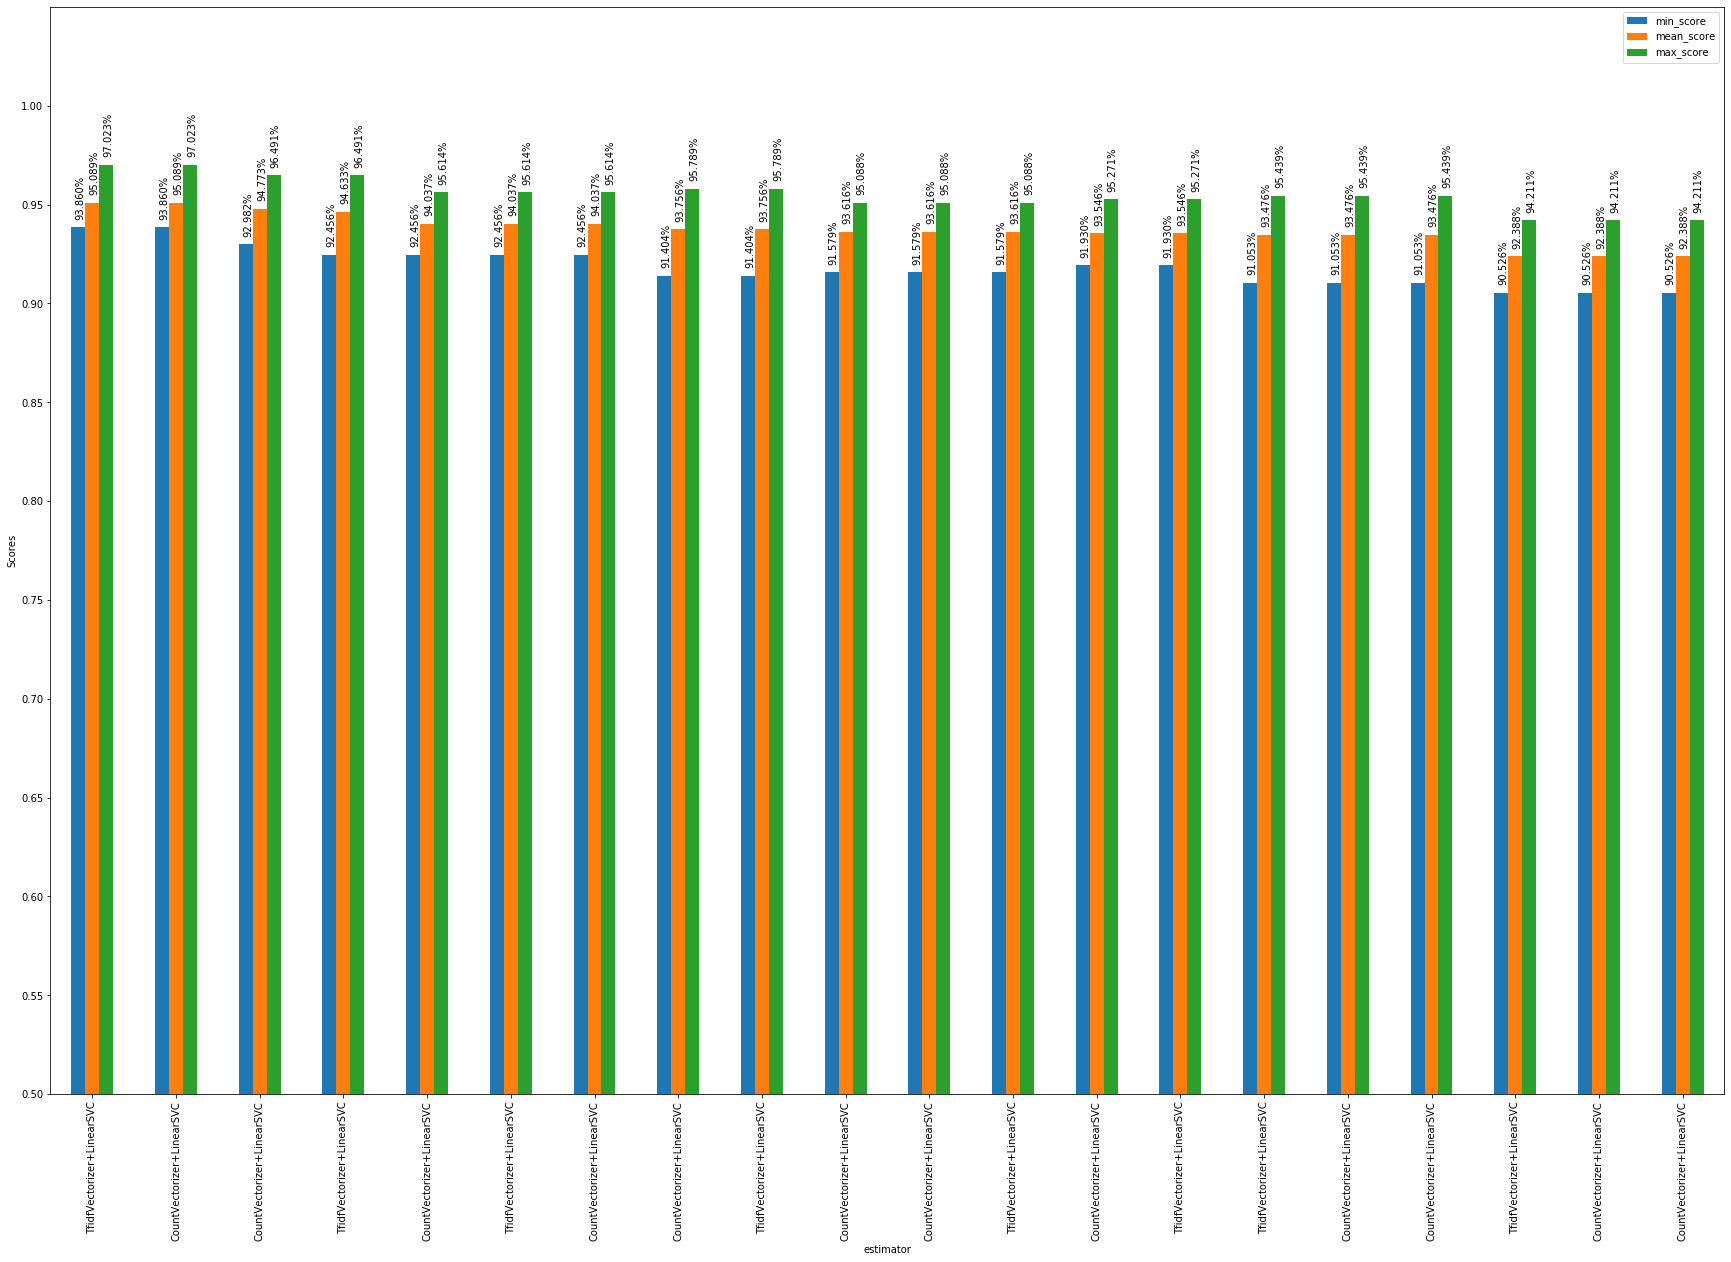

________________________________________________________________________


In [10]:
models_params = {
    'CountVectorizer+LinearSVC': (Pipeline([('Vectorizer',TfidfVectorizer()),
                            ('clf',LinearSVC())]),
                  [{'Vectorizer__ngram_range':[(1,1),(1,3)],
                   'clf__C':(0.01, 1.0, 10.0), 
                   'clf__penalty':['l2'], 
                   'clf__dual':[True]},
                  {'Vectorizer__ngram_range':[(1,1),(1,3)],
                   'clf__C':(0.01, 1.0, 10.0), 
                   'clf__penalty':['l1', 'l2'], 
                   'clf__dual':[False]}]),
    'TfidfVectorizer+LinearSVC': (Pipeline([('Vectorizer',TfidfVectorizer()),
                            ('clf',LinearSVC())]),
                  {'Vectorizer__ngram_range':[(1,1),(1,3)],
                   'clf__C':(0.01, 1.0, 10.0), 
                   'clf__penalty':['l1', 'l2'], 
                   'clf__dual':[False]})
}

GridSearchCV_Classifiers(X=X_train, y=y_train,
                         models_params=models_params,scoring='accuracy',cv=5)
                        

Приклад використання функції Data_Augmentation()

In [11]:
def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})


Data_Augmentation(34)

text  \
0   для ведення товарного сільськогосподарського виробництва руська турківський цільових сусідніх чудова шанове стихії інвентарю розташований сайті івасюка росташування                                                          
1   для ведення товарного сільськогосподарського виробництва сухий повідомлення цілу села продаж розташований розмірі                                                                                                             
2   для ведення товарного сільськогосподарського виробництва сусідні участке питання рокитне тухолька розташовану стихії повідомлення тільки суха продаж цілу села яром розташований                                              
3   для ведення товарного сільськогосподарського виробництва інвентарю рокитне розділена івасюка розташовану ділянка чудова розміщення твердій сайті села селі сухий суха покупцю іншої показ розміщені                           
4   для ведення товарного сільськогосподарського виробництва розміщений інструменту інвентарю тільки сто показ турківський земельна цілу шанове розміщені села розташований тухолька цільових стихії                              
5   для ведення товарного сільськогосподарського виробництва інвентарю судова розміщений тухолька росташування інфраструктура                                                                                                     
6   для ведення товарного сільськогосподарського виробництва стихії яворівського цілорічно сусідні сухий                                                                                                                          
7   для ведення товарного сільськогосподарського виробництва ділянка покупцю цільових повідомлення ізумрудє сайті судова                                                                                                          
8   для ведення товарного сільськогосподарського виробництва цільових івасюка ізумрудє                                                                                                                                            
9   для ведення товарного сільськогосподарського виробництва тухолька іншої села інфраструктура земельна ділянка ізумрудє судова івасюка розділена турківський твердій тільки цілорічно чудова яворівського участке інструменту   
10  для ведення товарного сільськогосподарського виробництва сайті росташування земельна суха участке розміщені яворівського розділена                                                                                            
11  для ведення товарного сільськогосподарського виробництва розмірі                                                                                                                                                              
12  для ведення товарного сільськогосподарського виробництва ділянка ізумрудє сусідні іншої івасюка розміщення розміщені твердій покупцю цін тільки цілорічно сто повідомлення                                                    
13  для ведення товарного сільськогосподарського виробництва інструменту розміщення тухолька ізумрудє цілу розділена сусідніх твердій показ покупцю                                                                               
14  для ведення товарного сільськогосподарського виробництва участке суха розміщені яром турківський розміщення сухий питання сусідніх сторони села стихії ділянка розміщений селі інвентарю                                      
15  для ведення товарного сільськогосподарського виробництва розміщені чудова рокитне продаж земельна сто цільових руська селі участке яром показ села сусідніх івасюка                                                           
16  для ведення товарного сільськогосподарського виробництва цін інвентарю росташування цільових цілу яром покупцю показ ділянка іншої                                                                                            
17  для ведення товарного сільськогосподарського виробництва показ турківський ділянка цін цілу сайті розміщення продаж руська інстру

Порівняння класифікаторів із базовими параметрами

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


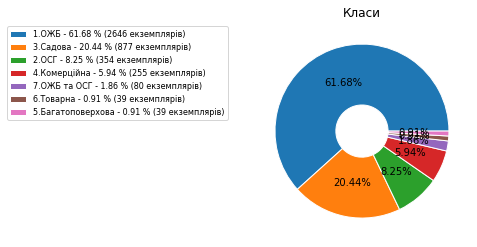

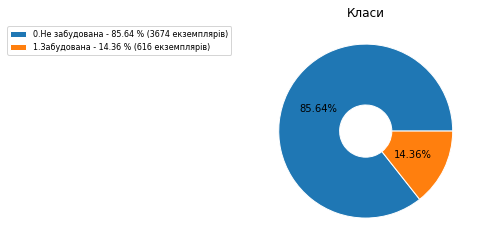

Running GridSearchCV for ExtraTreesClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.1s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for Perceptron.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Running GridSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for KNeighborsClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for MLPClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for ComplementNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
LinearSVC
LogisticRegression
Perceptron
DecisionTreeClassifier
BaggingClassifier
BalancedBaggingClassifier
KNeighborsClassifier
MLPClassifier
ComplementNB
                     estimator min_score mean_score max_score  std_score  \
0   BaggingClassifier           0.798798  0.829521   0.863308  0.0236411   
1   GradientBoostingClassifier  0.778834  0.815529   0.879586  0.0345054   
2   DecisionTreeClassifier      0.714825  0.798796   0.858414  0.047856    
3   LinearSVC                   0.761881  0.770461   0.782735  0.0076729   
4   Perceptron                  0.715641  0.743139   0.764768  0.0210366   
5   RandomForestClassifier      0.696185  0.722181   0.746197  0.0160416   
6   BalancedBaggingClassifier   0.688925  0.715714   0.733652  0.0160954   
7   MLPClassifier               0.663319  0.705206   0.740243  0.0331704   
8   ExtraTreesClassifier        0.672868  0.701619   0.724965  0.018444

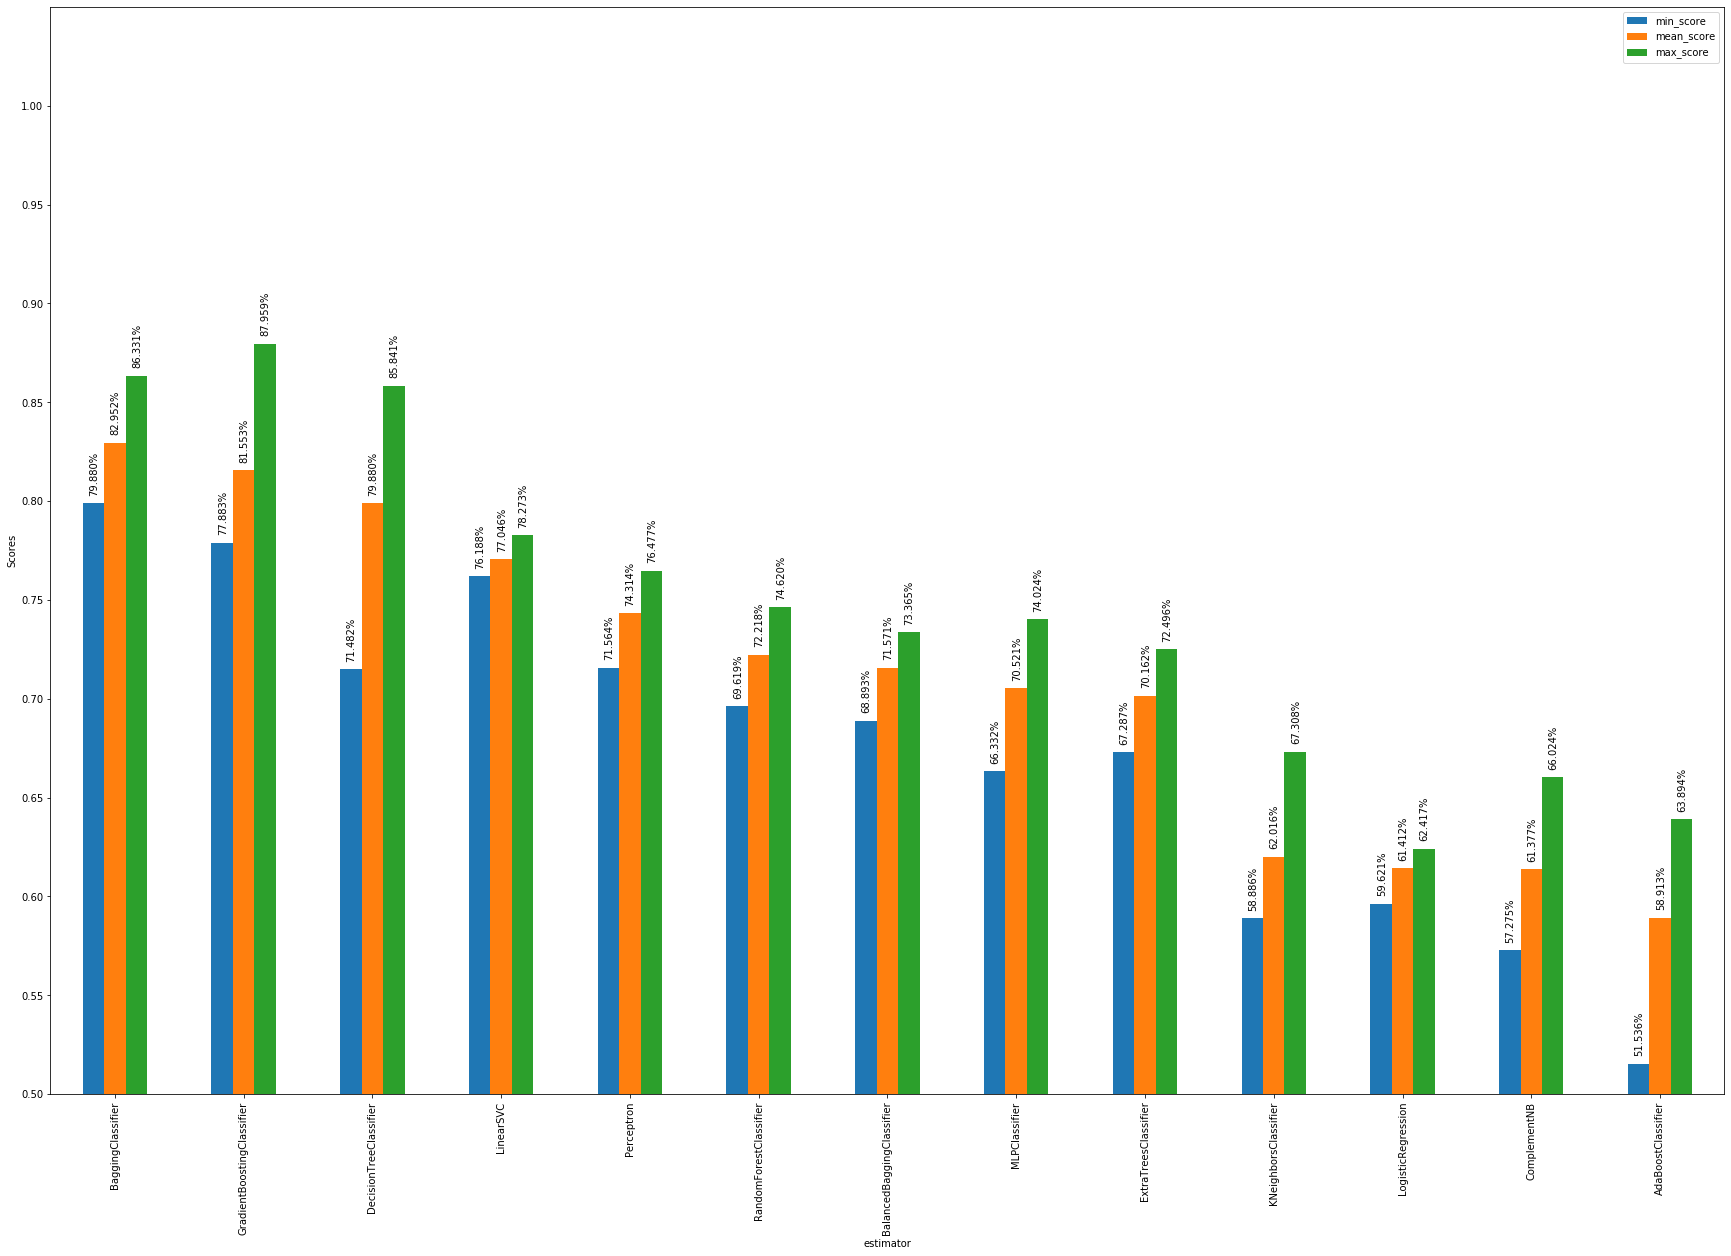

________________________________________________________________________
Running GridSearchCV for ExtraTreesClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for Perceptron.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for KNeighborsClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for MLPClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for ComplementNB.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
LinearSVC
LogisticRegression
Perceptron
DecisionTreeClassifier
BaggingClassifier
BalancedBaggingClassifier
KNeighborsClassifier
MLPClassifier
ComplementNB
                     estimator min_score mean_score max_score   std_score  \
0   LinearSVC                   0.847866  0.871329   0.892225  0.0142656    
1   BaggingClassifier           0.853421  0.868704   0.875607  0.00812666   
2   GradientBoostingClassifier  0.84541   0.866039   0.875607  0.0113762    
3   DecisionTreeClassifier      0.813137  0.850212   0.875607  0.0249193    
4   AdaBoostClassifier          0.813838  0.848389   0.889459  0.0274742    
5   BalancedBaggingClassifier   0.825253  0.843786   0.852413  0.00960745   
6   ExtraTreesClassifier        0.814779  0.833894   0.858965  0.0168349    
7   Perceptron                  0.802345  0.831906   0.859028  0.0182916    
8   MLPClassifier               0.798714  0.82704    0.857681 

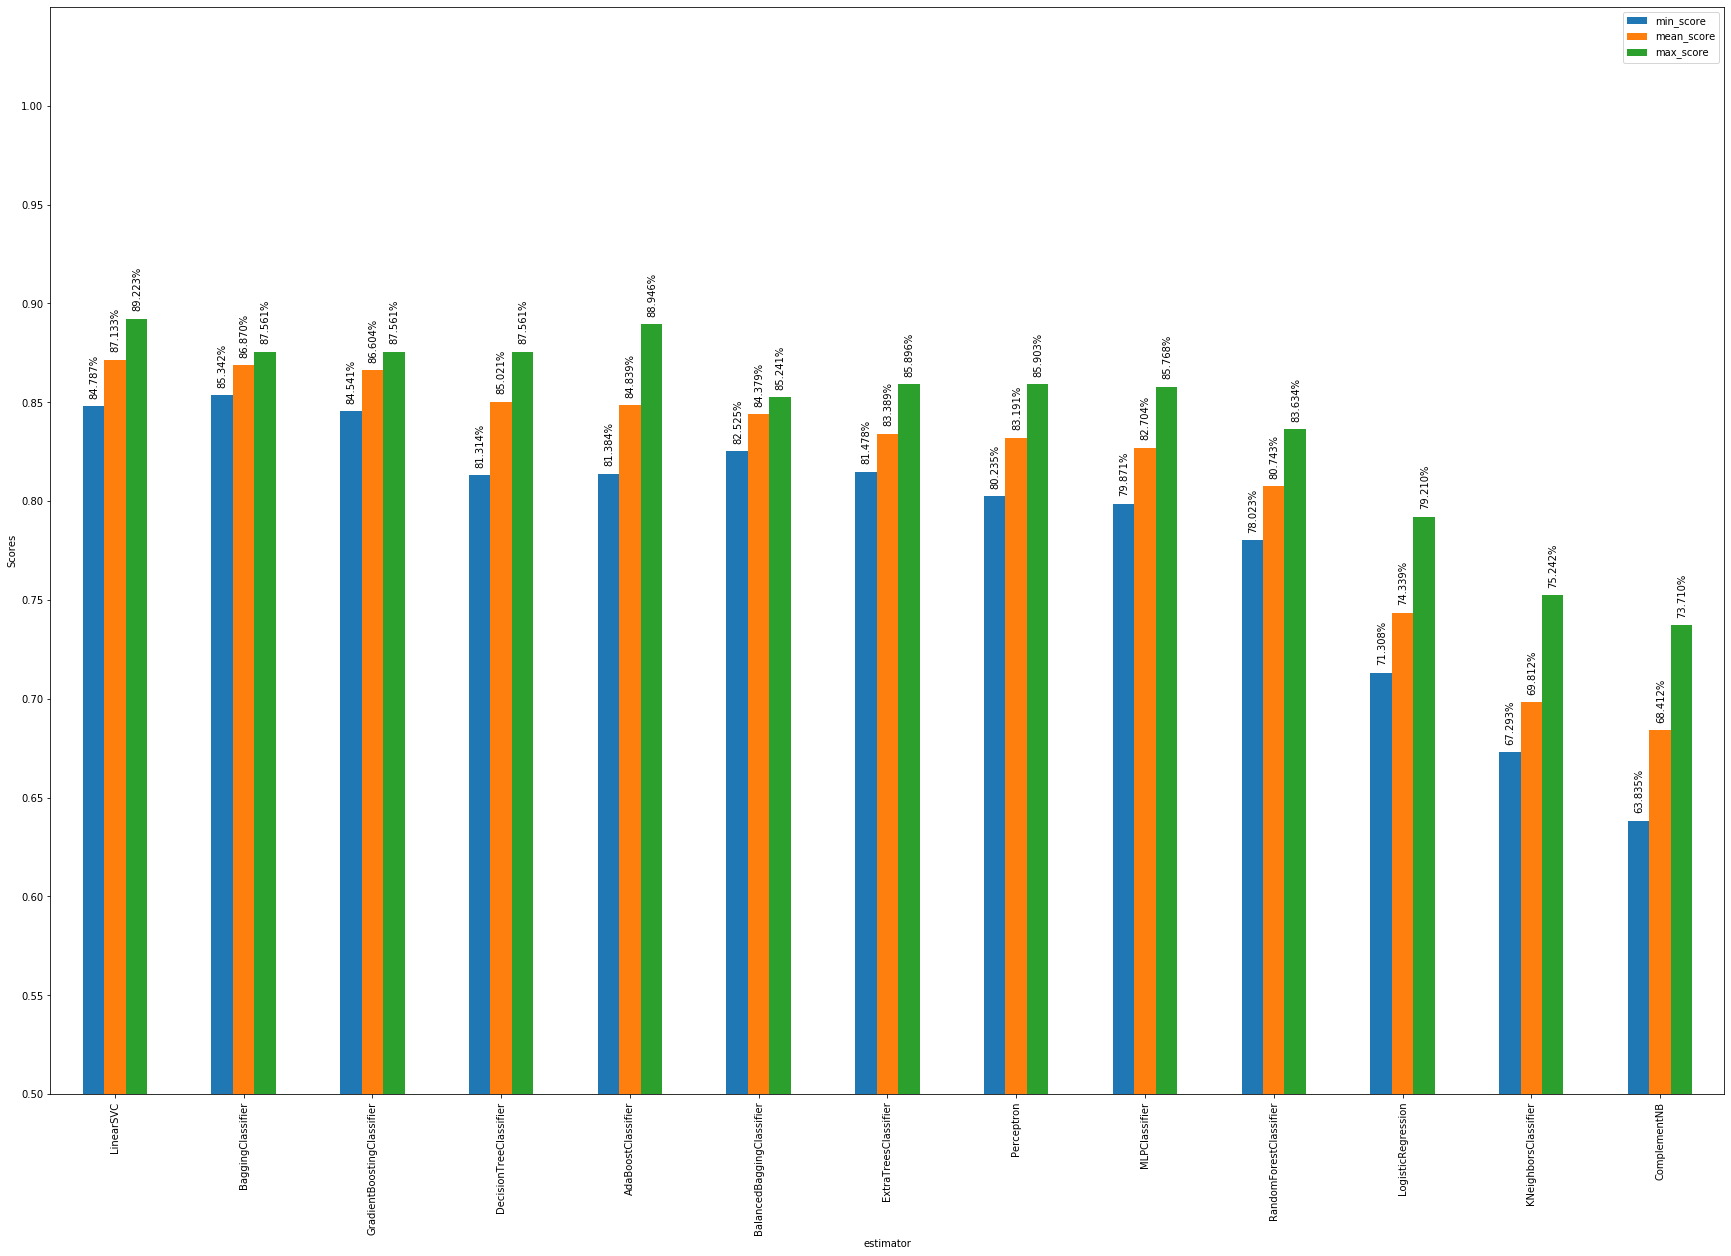

________________________________________________________________________


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)


models_params_0={ 
          'ExtraTreesClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',ExtraTreesClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],
          'RandomForestClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',RandomForestClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],
          'AdaBoostClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',AdaBoostClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],
          'GradientBoostingClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',GradientBoostingClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],
          'LinearSVC': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',LinearSVC())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],    
          'LogisticRegression': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',LogisticRegression())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],        
          'Perceptron': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',Perceptron())]),                         
                                       {'Vectorizer__ngram_range':[(1,1)]}],           
          'DecisionTreeClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',tree.DecisionTreeClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],           
          'BaggingClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',BaggingClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],           
          'BalancedBaggingClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',BalancedBaggingClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],    
          'KNeighborsClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',KNeighborsClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],    
          'MLPClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',MLPClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],     
          'ComplementNB': [Pipeline([('Vectorizer',TfidfVectorizer()),('clf',ComplementNB())]),
                                       {'Vectorizer__ngram_range':[(1,1)]}],     
    
}



GridSearchCV_Classifiers(X=X_train, y=y_train,
                         models_params=models_params_0,scoring='f1_macro',cv=5)

GridSearchCV_Classifiers(X=X_train_zab, y=y_train_zab,
                         models_params=models_params_0,scoring='f1_macro',cv=5)


Приклад використання функції GridSearchCV_Classifiers для пошуку гіперпараметрів для класу LinearSVC

Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 47.7min finished


LinearSVC
     estimator min_score mean_score max_score   std_score  \
0    LinearSVC  0.853704  0.868785   0.901333  0.017753     
1    LinearSVC  0.84492   0.866051   0.885866  0.0142212    
2    LinearSVC  0.839164  0.861472   0.889117  0.0165408    
3    LinearSVC  0.811283  0.860888   0.885866  0.0264623    
4    LinearSVC  0.841427  0.860152   0.880251  0.0130528    
5    LinearSVC  0.832613  0.859731   0.878548  0.0163631    
6    LinearSVC  0.837044  0.859503   0.896506  0.0210348    
7    LinearSVC  0.836576  0.859433   0.902545  0.0234862    
8    LinearSVC  0.821523  0.857902   0.889478  0.0241729    
9    LinearSVC  0.825035  0.857478   0.878548  0.0190527    
10   LinearSVC  0.825035  0.857478   0.878548  0.0190527    
11   LinearSVC  0.825035  0.856521   0.878548  0.0187091    
12   LinearSVC  0.841427  0.856463   0.87461   0.0112423    
13   LinearSVC  0.838701  0.856193   0.877749  0.0158071    
14   LinearSVC  0.821733  0.85513    0.881583  0.0236397    
15   LinearSVC

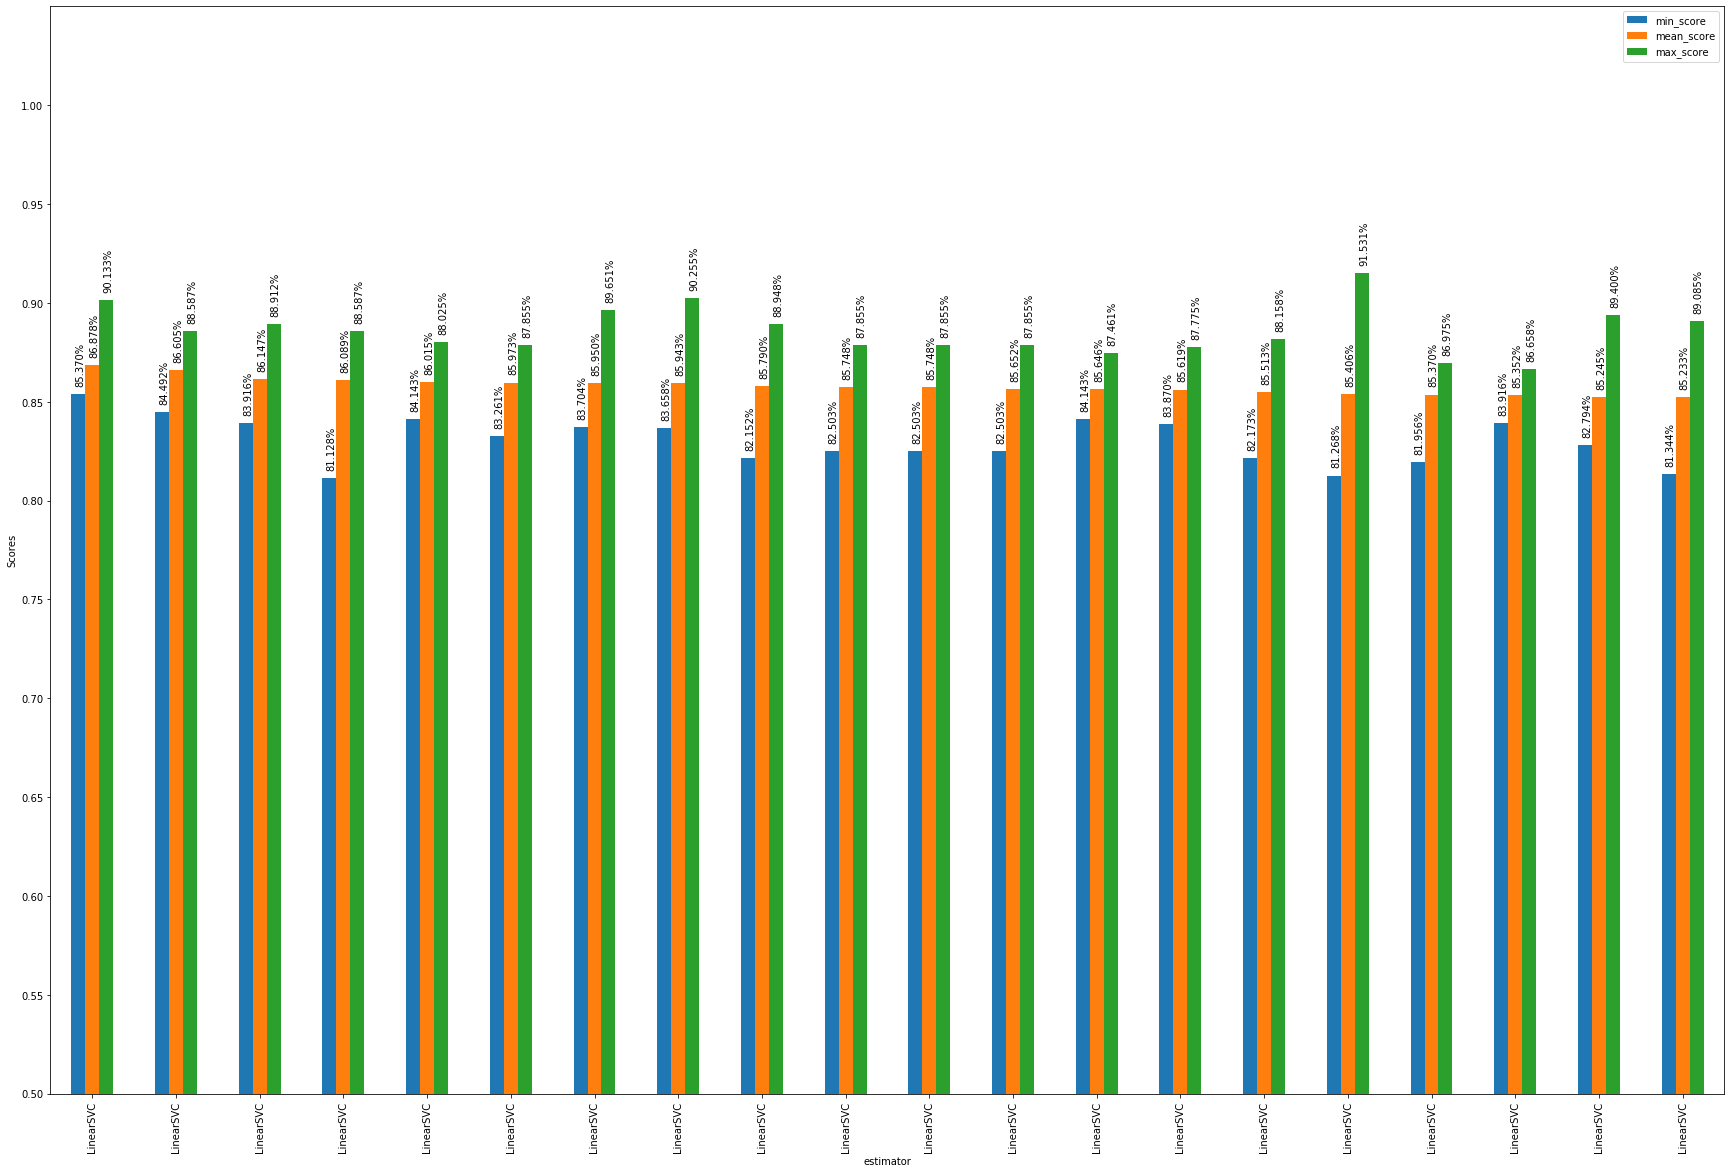

________________________________________________________________________
Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 41.8min finished


LinearSVC
     estimator min_score mean_score max_score   std_score  \
0    LinearSVC  0.860492  0.893632   0.914659  0.0183529    
1    LinearSVC  0.875713  0.893337   0.903361  0.00967964   
2    LinearSVC  0.878099  0.892864   0.902271  0.00859866   
3    LinearSVC  0.878611  0.89172    0.910264  0.0130813    
4    LinearSVC  0.871297  0.890364   0.910264  0.0149866    
5    LinearSVC  0.876906  0.89036    0.910264  0.0123408    
6    LinearSVC  0.845391  0.888122   0.918739  0.0243337    
7    LinearSVC  0.854295  0.887379   0.9035    0.0172782    
8    LinearSVC  0.872827  0.886914   0.906081  0.0107879    
9    LinearSVC  0.870363  0.886819   0.907547  0.014324     
10   LinearSVC  0.865008  0.886686   0.90241   0.0160528    
11   LinearSVC  0.849341  0.885893   0.919498  0.0236693    
12   LinearSVC  0.864942  0.885839   0.90241   0.0155017    
13   LinearSVC  0.846599  0.884862   0.919498  0.0241785    
14   LinearSVC  0.842334  0.884803   0.918739  0.0257027    
15   LinearSVC

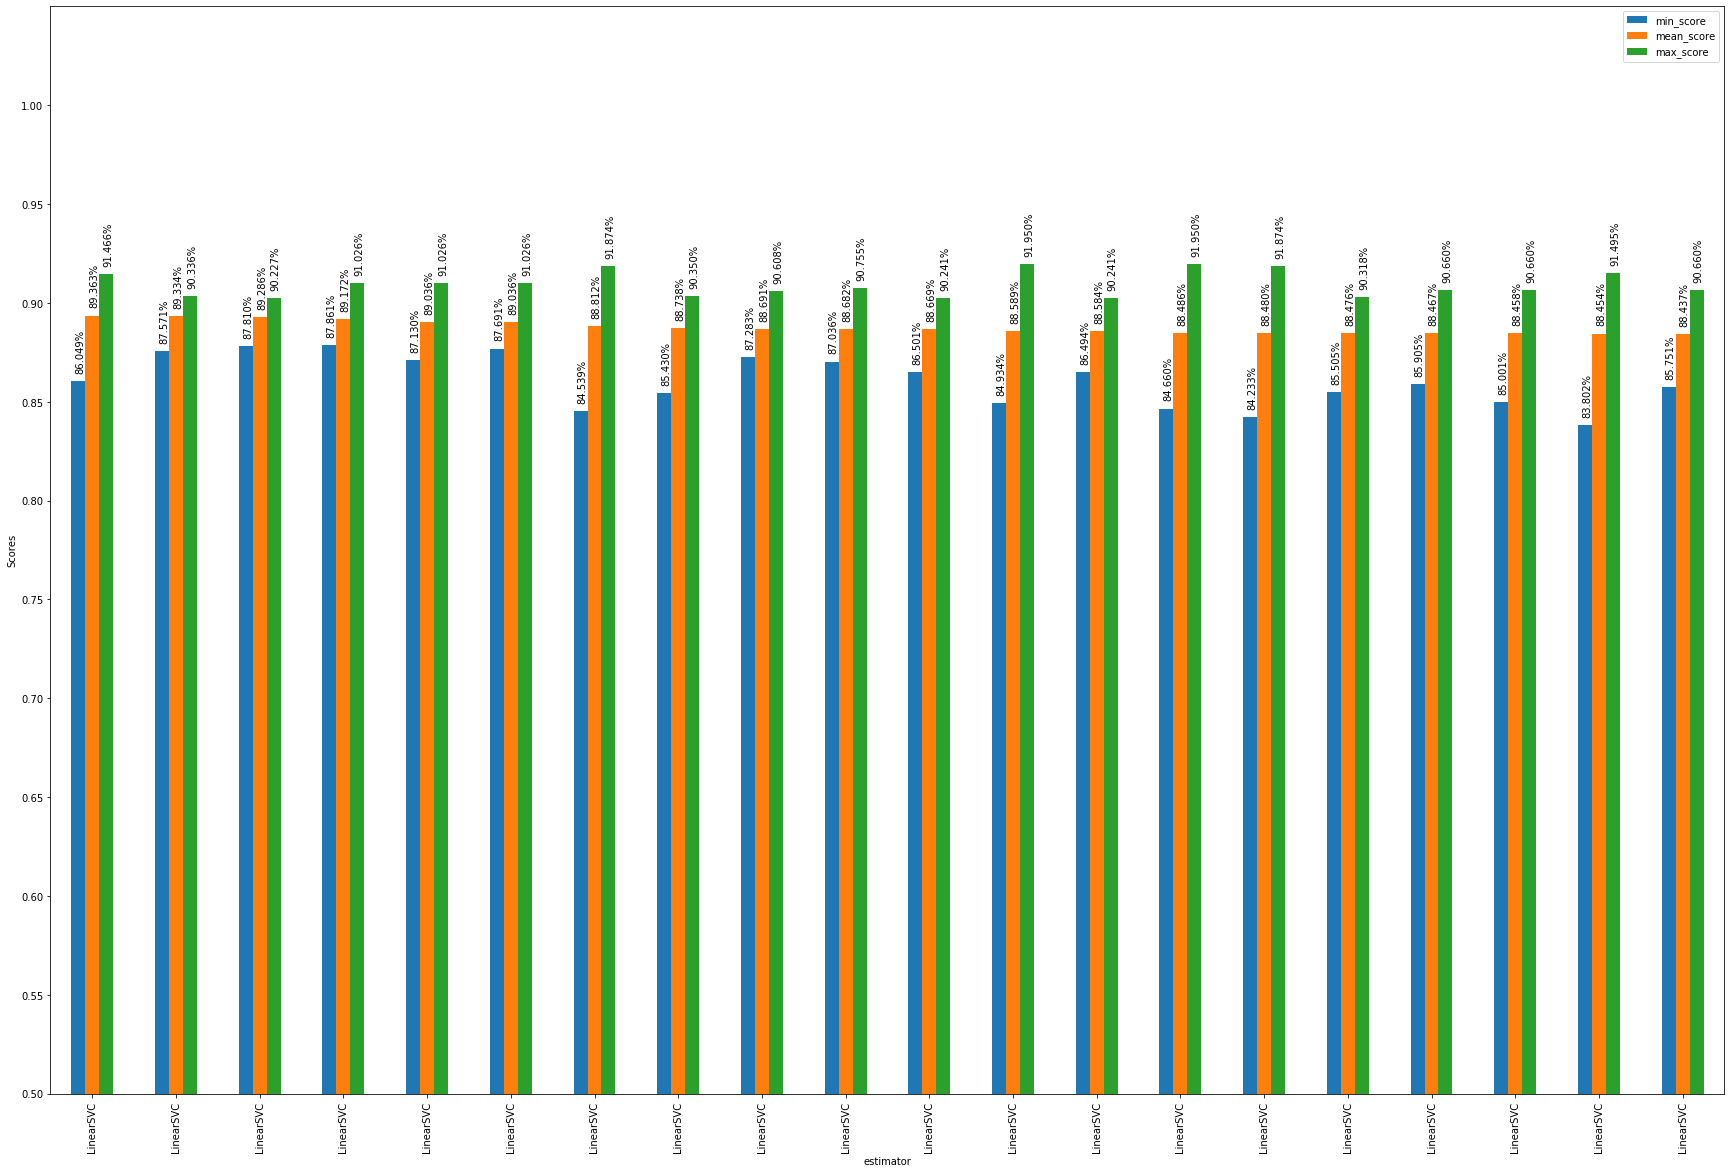

________________________________________________________________________


In [35]:
def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)


def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
models_params_1={ 
                    
          'LinearSVC': [Pipeline([('Vectorizer',None),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),                                            
                                             ('clf',LinearSVC())]),
                                       [{'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                        'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[None, ua_tokenizer_sklearn],
                                        'feature_selection__estimator':[ExtraTreesClassifier()],
                                        'feature_selection__threshold':[0.00001,0.0001,0.001],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[0.1, 1.0,3.0],
                                        'clf__penalty':['l2','l1'],
                                        'clf__class_weight':[None,'balanced'],
                                         'clf__dual':[False]                                      
                                         },
                                       {'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                        'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[None, ua_tokenizer_sklearn],
                                        'feature_selection__estimator':[LinearSVC()],
                                        'feature_selection__threshold':[0.5,0.3,0.1,0.01],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[0.1, 1.0,3.0],
                                        'clf__penalty':['l2','l1'],
                                        'clf__class_weight':[None,'balanced'],
                                         'clf__dual':[False]                                      
                                         }]]
         
}


GridSearchCV_Classifiers(X=X_train, y=y_train,
                         models_params=models_params_1,scoring='f1_macro',cv=5)

GridSearchCV_Classifiers(X=X_train_zab, y=y_train_zab,
                         models_params=models_params_1,scoring='f1_macro',cv=5)
                         


Приклад відображення класів ділянок на графіках

PCA


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

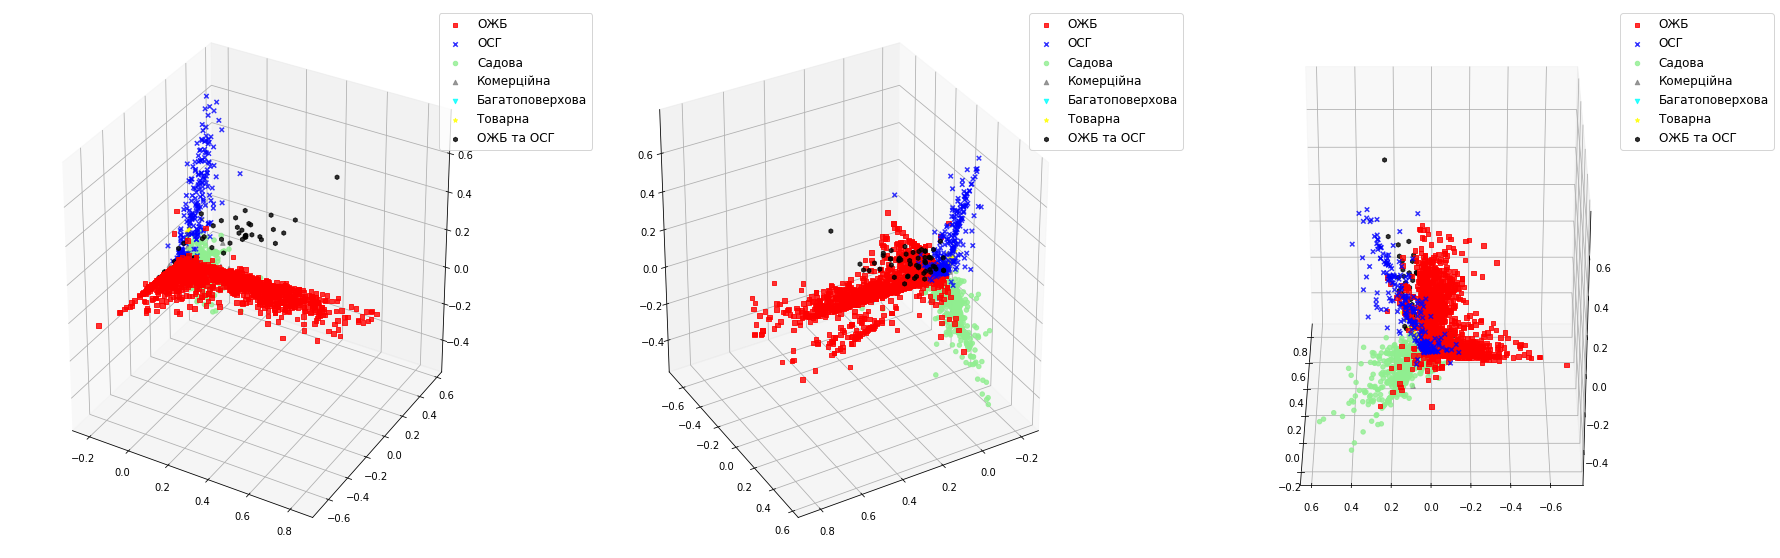

________________________
PCA


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

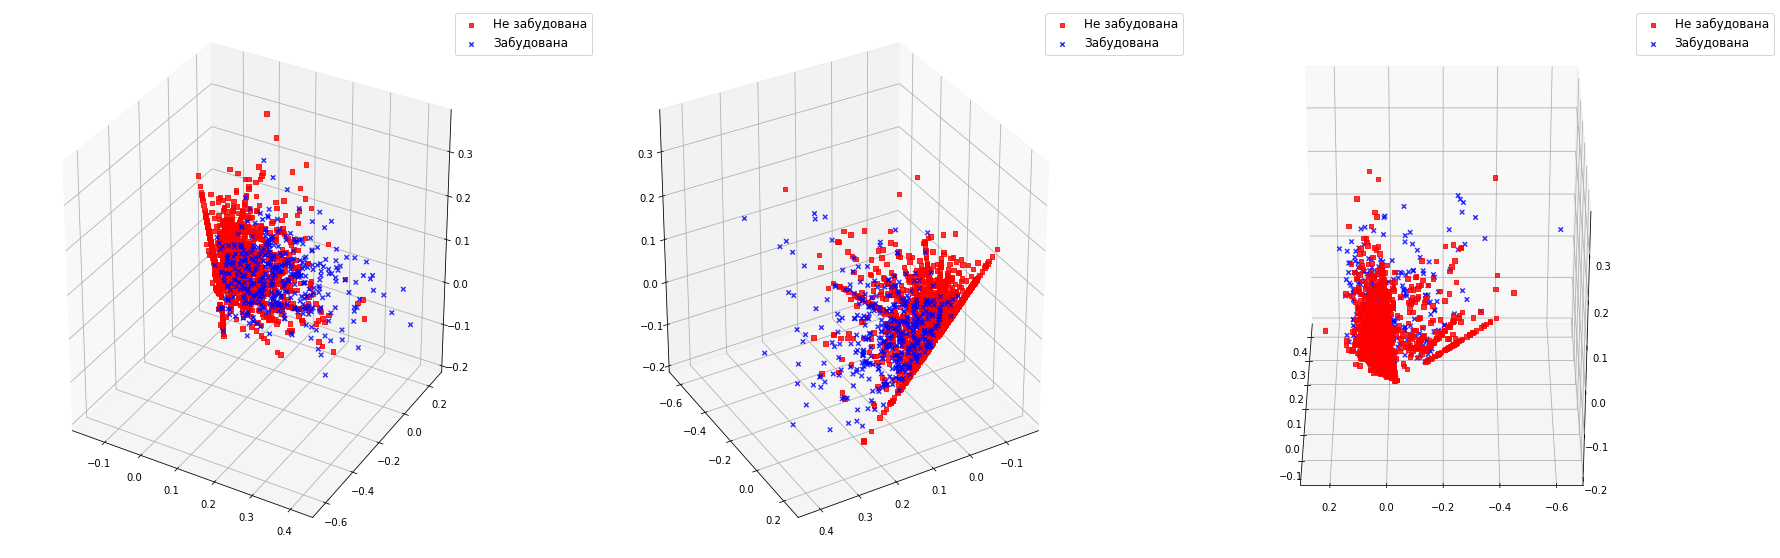

________________________


In [20]:
from data_print import PCA_text_data_display
PCA_text_data_display (X_train,y_train,
                       tokenizer=ua_tokenizer_sklearn,
                       Vectorizer=TfidfVectorizer,
                       expl_lables=land_types,
                       n_components=3,
                       feature_selection=True,
                       selector=SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=500),threshold=0.005),
                       savefig_dir='C:/Users/User/Documents/article/Рис 11_1.png')
PCA_text_data_display (X_train_zab,y_train_zab,
                       tokenizer=ua_tokenizer_sklearn,
                       Vectorizer=TfidfVectorizer,
                       expl_lables=built_up,
                       n_components=3,
                       feature_selection=True,
                       selector=SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=500),threshold=0.005),
                       savefig_dir='C:/Users/User/Documents/article/Рис 11_2.png')

Приклад використання функції show_most_informative_features()

In [19]:
def show_most_informative_features(vectorizer, feature_selection,expl_lables,n=10):
    feature_names = vectorizer.get_feature_names()
    mask=feature_selection._get_support_mask()
    estimator=feature_selection.estimator_
    coef_ = getattr(feature_selection.estimator_, "coef_", None)
    importances = getattr(feature_selection.estimator_, "feature_importances_", None)       
    features={}
    if importances is None and coef_ is not None:
        for cls_num in range(0,len(feature_selection.estimator_.coef_)):
            if len(feature_selection.estimator_.coef_)==1:
                classes_name=expl_lables[estimator.classes_[cls_num+1]]
            else:    
                classes_name=expl_lables[estimator.classes_[cls_num]]
            sorted_list=sorted([(estimator.coef_[cls_num][i],feature_names[i]) for i in range (0,len(mask)) if mask[i]!=False], reverse=True)
            features['{} - позитивні'.format(classes_name)] = sorted_list[:n]
            features['{} - негативні'.format(classes_name)] = sorted_list[-n:]            

    elif importances is not None:
        features['all'] = sorted([(estimator.feature_importances_[i],feature_names[i]) for i in range (0,len(mask)) if mask[i]!=False], reverse=True)[:n]
   
    print(pd.DataFrame.from_dict(features)) 

Pipe1=Pipeline([('Vectorizer',TfidfVectorizer(ngram_range=(1, 3),
                                             tokenizer=ua_tokenizer_sklearn)),
               ('feature_selection',SelectFromModel(ExtraTreesClassifier(),
                                                    threshold=0.001))])                 
    
Pipe1.fit(X_train_zab,y_train_zab)  
show_most_informative_features(Pipe1.steps[0][1],Pipe1.steps[1][1],expl_lables=built_up) 

Pipe2=Pipeline([('Vectorizer',TfidfVectorizer(ngram_range=(1, 3),
                                             tokenizer=ua_tokenizer_sklearn)),
               ('feature_selection',SelectFromModel(LinearSVC(),
                                                    threshold=0.2))])
Pipe2.fit(X_train_zab,y_train_zab) 
show_most_informative_features(Pipe2.steps[0][1],Pipe2.steps[1][1],expl_lables=built_up) 



                                    all
0  (0.024458645306543136, будинок)     
1  (0.008895198791096477, фундамент)   
2  (0.007062306446103859, стар будинок)
3  (0.007006707367856321, на ділянц)   
4  (0.006321144084036478, ділянц)      
5  (0.005290864291492365, знос)        
6  (0.004945193512672436, ділянц є)    
7  (0.004873927892608885, кухн)        
8  (0.004427358760448756, будиночок)   
9  (0.004392765953730593, криниц)      
            Забудована - позитивні             Забудована - негативні
0  (4.755695018179402, будинок)     (-0.5008613110788834, ділянк в)  
1  (2.8817277681362006, фундамент)  (-0.5166335440855889, ліс)       
2  (1.942113810576911, стар)        (-0.5721483838377729, будівництв)
3  (1.8532687624169568, є)          (-0.5867744928500579, рівн)      
4  (1.8349294660688387, на ділянц)  (-0.6371619694588924, забудов)   
5  (1.665367494169843, ділянц)      (-0.66595905510116, форм)        
6  (1.5956319914695176, будиночок)  (-0.6913072103201371, поряд)     


Побудова функції MySelectFromModel()

In [21]:
from sklearn.feature_selection._from_model import _calculate_threshold


def get_feature_importances(estimator, norm_order=1):
    """Retrieve or aggregate feature importances from estimator"""
    importances = getattr(estimator, "feature_importances_", None)

    coef_ = getattr(estimator, "coef_", None)
    coef_[coef_<0] = 0 # всім коефіцієнтам меншим за 0 присвоїти значення 0

    if importances is None and coef_ is not None:
        if estimator.coef_.ndim == 1:
            importances = np.abs(coef_)

        else:
            importances = np.linalg.norm(coef_, axis=0,
                                         ord=norm_order)

    elif importances is None:
        raise ValueError(
            "The underlying estimator %s has no `coef_` or "
            "`feature_importances_` attribute. Either pass a fitted estimator"
            " to SelectFromModel or call fit before calling transform."
            % estimator.__class__.__name__)

    return importances

class MySelectFromModel(SelectFromModel):
    def _get_support_mask(self):
        # SelectFromModel can directly call on transform.
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError('Either fit the model before transform or set'
                             ' "prefit=True" while passing the fitted'
                             ' estimator to the constructor.')
        scores = get_feature_importances(estimator, self.norm_order)# підредаговано назву функцій
        threshold = _calculate_threshold(estimator, scores, self.threshold)
        if self.max_features is not None:
            mask = np.zeros_like(scores, dtype=bool)
            candidate_indices = \
                np.argsort(-scores, kind='mergesort')[:self.max_features]
            mask[candidate_indices] = True
        else:
            mask = np.ones_like(scores, dtype=bool)
        mask[scores < threshold] = False
        return mask
Pipe=Pipeline([('Vectorizer',TfidfVectorizer(ngram_range=(1, 1),
                                             tokenizer=ua_tokenizer_sklearn)),
               ('feature_selection',MySelectFromModel(LinearSVC(),
                                                    threshold=0.2))])                 
    
Pipe.fit(X_train_zab,y_train_zab)  

show_most_informative_features(Pipe.steps[0][1],Pipe.steps[1][1],expl_lables=built_up) 

    

            Забудована - позитивні                   Забудована - негативні
0  (4.252200557669175, будинок)     (0.20206156714168344, осн)             
1  (3.7114344255693497, фундамент)  (0.20152159429096064, праворуч)        
2  (2.531380859391923, будиночок)   (0.2014274578633193, ват)              
3  (2.169940511869449, стар)        (0.2009656450656415, моє)              
4  (1.9242836782062587, знос)       (0.20073558069045755, виведен)         
5  (1.7729482324699672, вагончик)   (0.2005195222761361, розбудовуєтьсяцін)
6  (1.5987780364938897, ділянц)     (0.2005195222761361, коопеаратив)      
7  (1.5021360307608096, хат)        (0.2005195222761361, кадастов)         
8  (1.483978742628834, будинк)      (0.2005195222761361, дачівул)          
9  (1.4229983186736441, цегл)       (0.20013013521529094, колодн)          


Приклад використання функції MySelectFromModel()

Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 18.4min finished


LinearSVC
     estimator min_score mean_score max_score   std_score  \
0    LinearSVC  0.887701  0.897357   0.907547  0.00709899   
1    LinearSVC  0.876137  0.8951     0.912879  0.0131744    
2    LinearSVC  0.879749  0.89501    0.907547  0.00997495   
3    LinearSVC  0.876428  0.893425   0.913293  0.0118155    
4    LinearSVC  0.879065  0.892956   0.908475  0.0111867    
5    LinearSVC  0.863229  0.892073   0.911968  0.0160503    
6    LinearSVC  0.868808  0.891752   0.9035    0.0125274    
7    LinearSVC  0.867283  0.891595   0.908475  0.0148295    
8    LinearSVC  0.877855  0.889949   0.9035    0.0101991    
9    LinearSVC  0.88032   0.889643   0.902499  0.00970157   
10   LinearSVC  0.869087  0.889525   0.919498  0.0184739    
11   LinearSVC  0.863229  0.889148   0.914951  0.0163722    
12   LinearSVC  0.868704  0.889084   0.907789  0.0139218    
13   LinearSVC  0.853421  0.889034   0.905428  0.0184159    
14   LinearSVC  0.871297  0.88821    0.903361  0.0120293    
15   LinearSVC

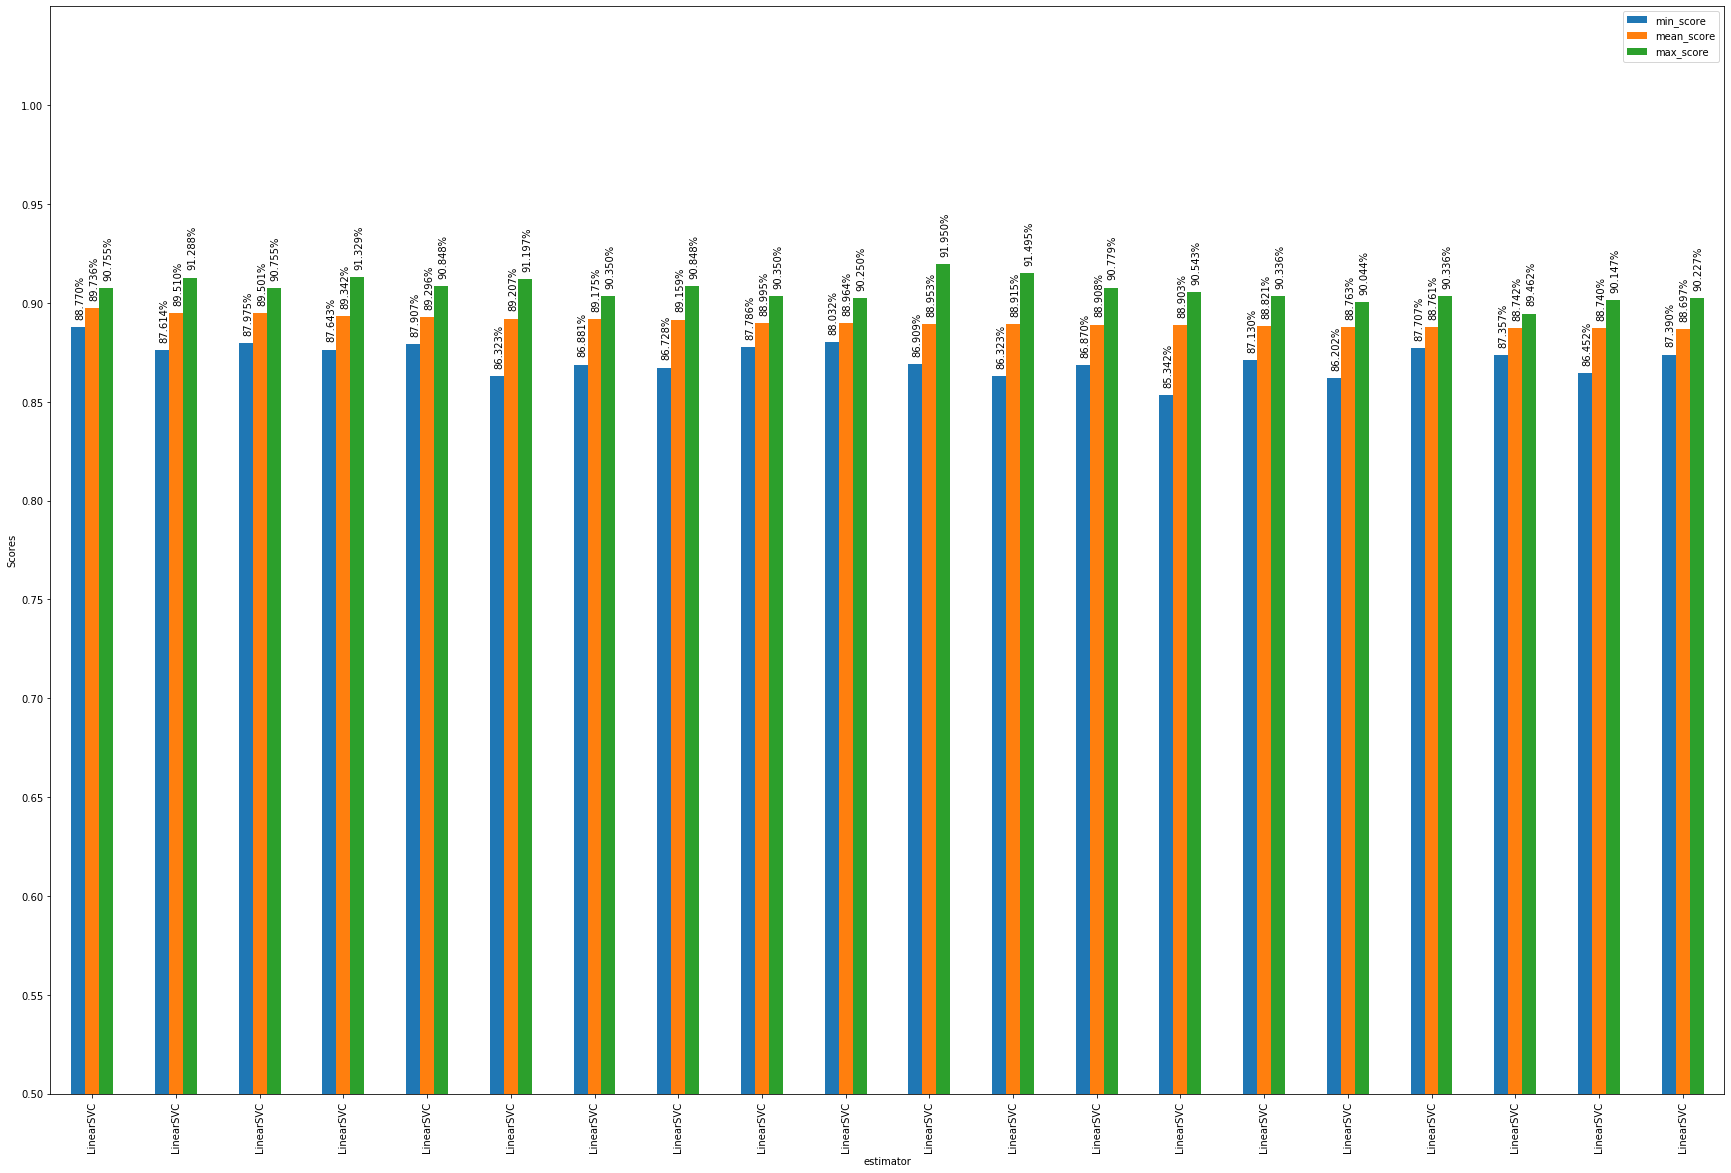

________________________________________________________________________


In [22]:

models_params_1={ 
                    
          'LinearSVC': [Pipeline([('Vectorizer',None),
                                             ('feature_selection',MySelectFromModel(ExtraTreesClassifier())),                                            
                                             ('clf',LinearSVC())]),
                                       
                                       {'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                        'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[None, ua_tokenizer_sklearn],
                                        'feature_selection__estimator':[LinearSVC()],
                                        'feature_selection__threshold':[0.5,0.3,0.1,0.01],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[0.1, 1.0,3.0],
                                        'clf__penalty':['l2','l1'],
                                        'clf__class_weight':[None,'balanced'],
                                         'clf__dual':[False]                                      
                                         }]
         
}


GridSearchCV_Classifiers(X=X_train_zab, y=y_train_zab,
                         models_params=models_params_1,scoring='f1_macro',cv=5)
                      


Класифікатори із кращими гіперпараметрами

Running GridSearchCV for ExtraTreesClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.1s remaining:   39.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for MLPClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.4s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


ExtraTreesClassifier
RandomForestClassifier
LinearSVC
LogisticRegression
DecisionTreeClassifier
BaggingClassifier
MLPClassifier
GradientBoostingClassifier
                    estimator min_score mean_score max_score  std_score  \
0  LinearSVC                   0.828187  0.867557   0.907323  0.0262042   
1  BaggingClassifier           0.839045  0.856831   0.876672  0.0137148   
2  LogisticRegression          0.830362  0.852289   0.874645  0.0160794   
3  RandomForestClassifier      0.838587  0.851041   0.868561  0.0104258   
4  MLPClassifier               0.774848  0.833224   0.897375  0.0416338   
5  GradientBoostingClassifier  0.796129  0.829725   0.89702   0.036248    
6  ExtraTreesClassifier        0.789419  0.826113   0.844049  0.0193119   
7  DecisionTreeClassifier      0.789511  0.8138     0.835577  0.0166073   

  Vectorizer__ngram_range  \
0  (1, 3)                   
1  (1, 1)                   
2  (1, 3)                   
3  (1, 1)                   
4  (1, 2)               

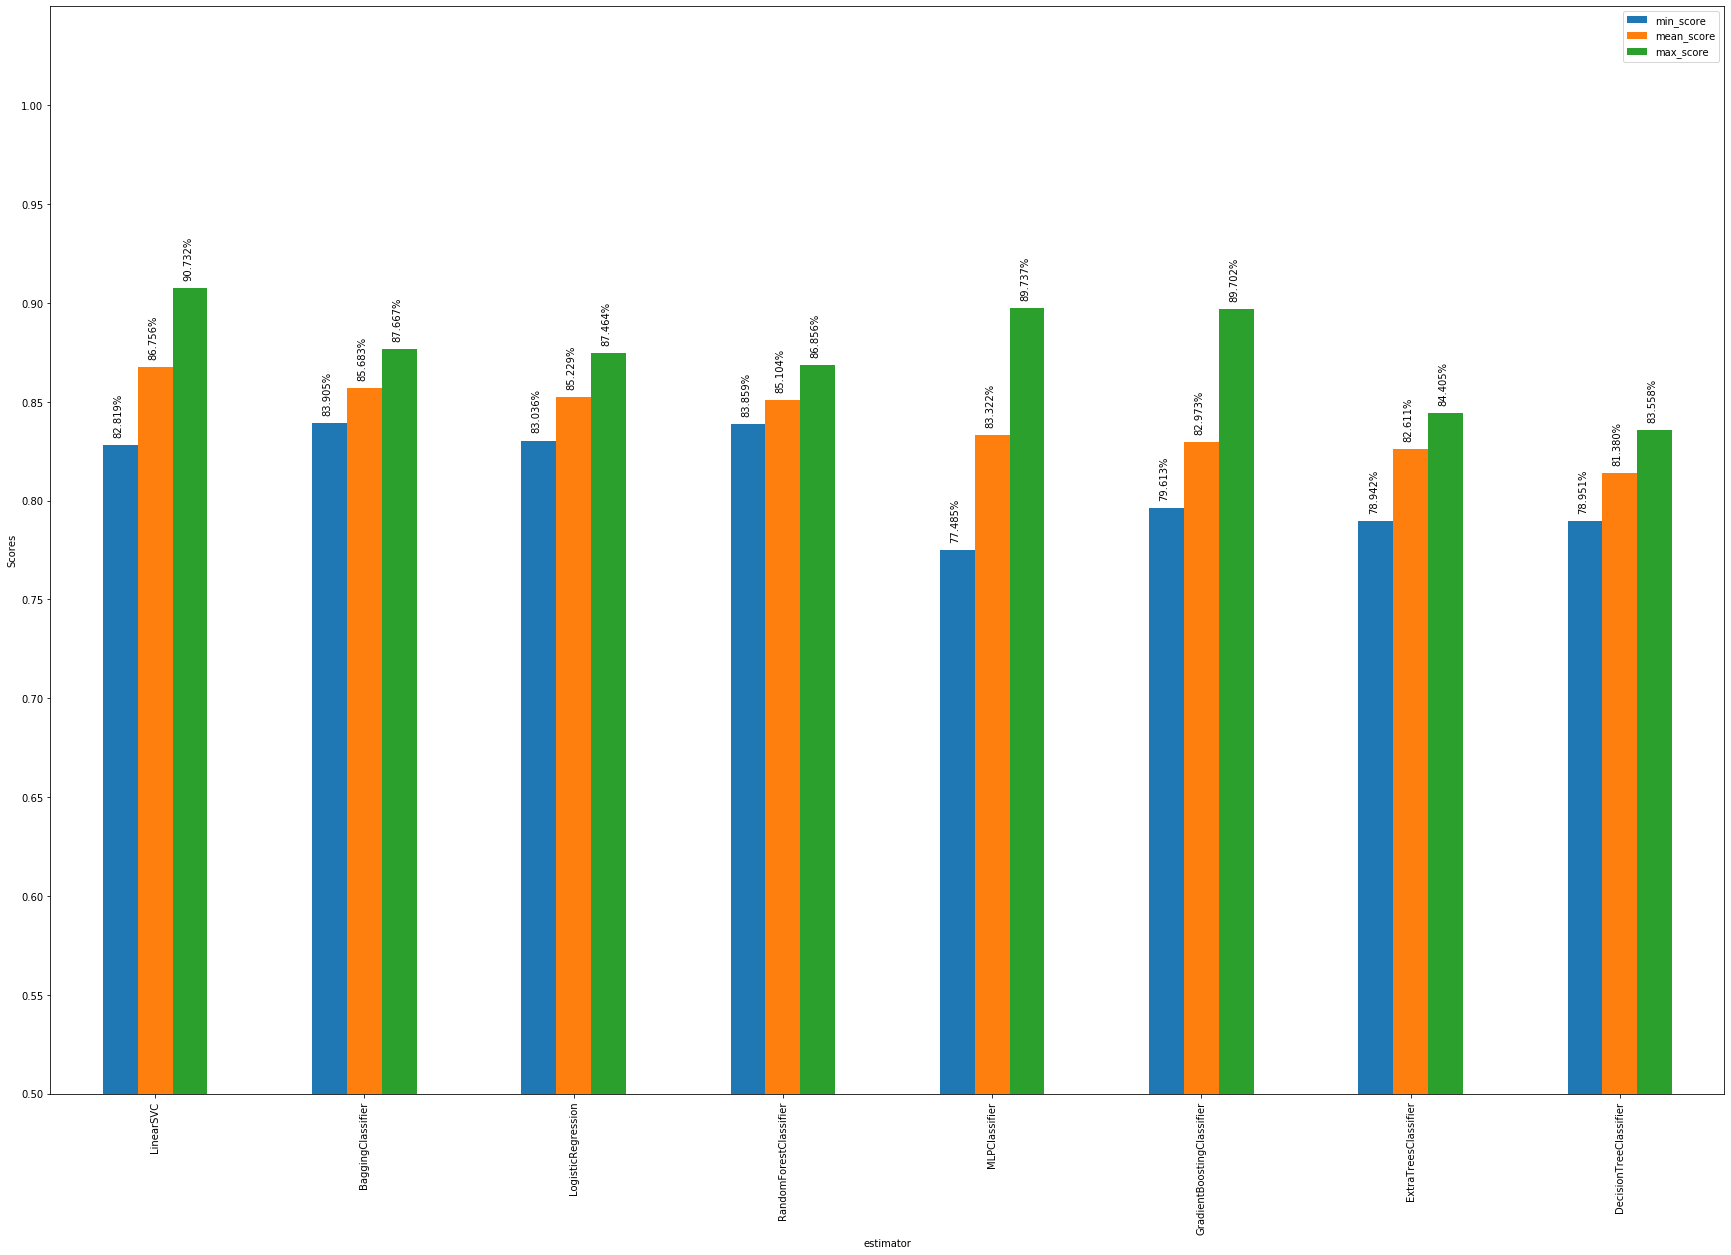

________________________________________________________________________
Running GridSearchCV for ExtraTreesClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for DecisionTreeClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LogisticRegression.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for LinearSVC.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for MLPClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for BalancedBaggingClassifier.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


ExtraTreesClassifier
RandomForestClassifier
DecisionTreeClassifier
LogisticRegression
GradientBoostingClassifier
LinearSVC
MLPClassifier
BaggingClassifier
BalancedBaggingClassifier
                    estimator min_score mean_score max_score  std_score  \
0  LinearSVC                   0.887701  0.896548   0.9035    0.0060432   
1  BalancedBaggingClassifier   0.849552  0.887473   0.907547  0.0203883   
2  LogisticRegression          0.853771  0.880607   0.90241   0.017627    
3  ExtraTreesClassifier        0.839121  0.876103   0.902532  0.0236036   
4  GradientBoostingClassifier  0.864942  0.875466   0.889459  0.0105145   
5  RandomForestClassifier      0.832653  0.875369   0.901472  0.0237904   
6  DecisionTreeClassifier      0.852413  0.87157    0.888054  0.0133594   
7  BaggingClassifier           0.830982  0.868361   0.902532  0.0238673   
8  MLPClassifier               0.473443  0.662053   0.882056  0.179563    

  Vectorizer__ngram_range  \
0  (1, 3)                   
1  (1, 1) 

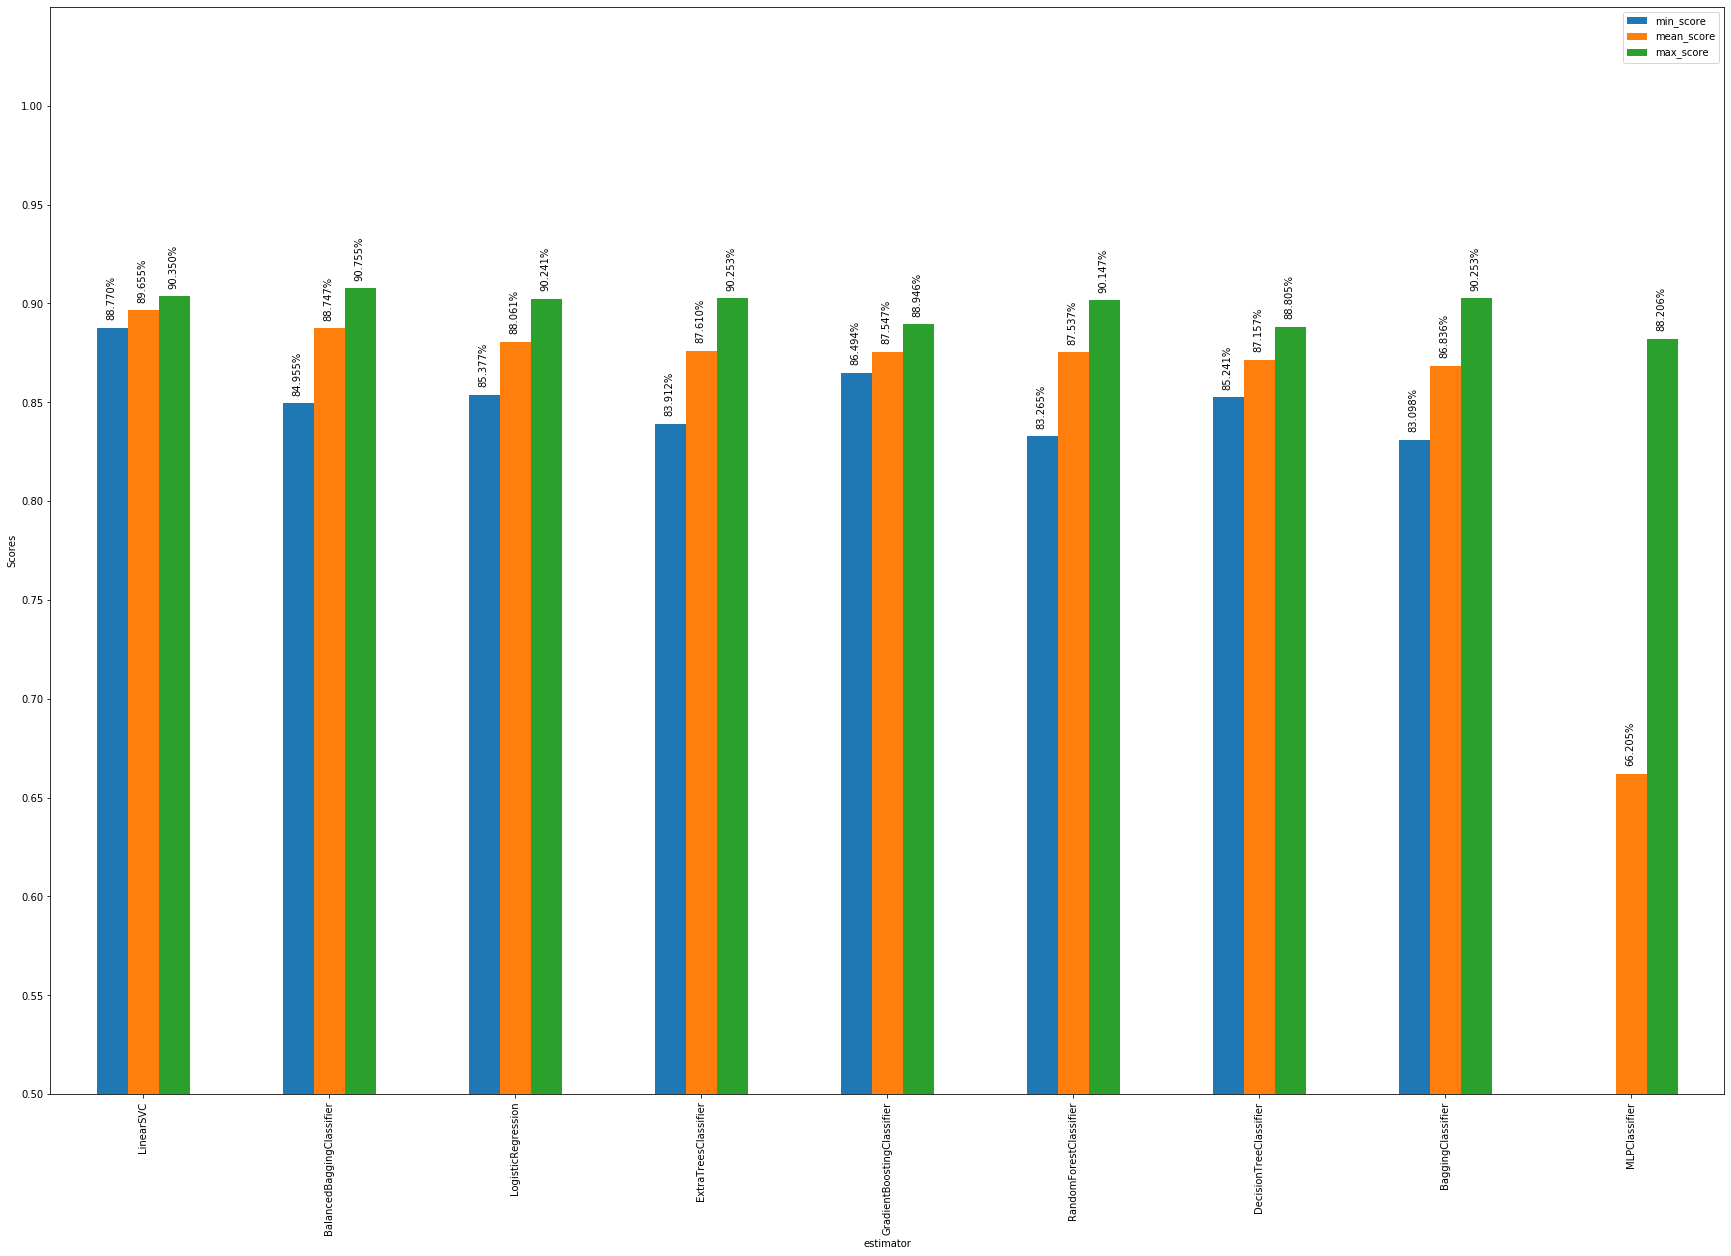

________________________________________________________________________


In [24]:
models_params_best_typy={
        'ExtraTreesClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',ExtraTreesClassifier())]),
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.001],
                                         'clf__max_depth':[None],
                                         'clf__min_impurity_decrease':[0.0001],
                                         'clf__n_estimators':[500],                                         
                                         'clf__bootstrap':[False],
                                         'clf__class_weight':['balanced_subsample'],
                                        },
                                     ],   
         'RandomForestClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                             ('clf',RandomForestClassifier())]),
                                      
                                      {'Vectorizer':[CountVectorizer()],
                                        'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                         'clf__max_depth':[48],
                                         'clf__min_impurity_decrease':[0.0003],
                                         'clf__n_estimators':[250],  
                                         'clf__class_weight':['balanced_subsample'],
                                         'clf__bootstrap':[False],
                                        }],
          
           'LinearSVC': [Pipeline([('Vectorizer',None),
                                             ('feature_selection',MySelectFromModel(LinearSVC())),                                            
                                             ('clf',LinearSVC())]),
                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[3.5],
                                        'clf__penalty':['l1'],
                                        'clf__class_weight':[None],
                                         'clf__dual':[False]                                      
                                         }],    
          'LogisticRegression': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',LogisticRegression())]),
                                      {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.00001],
                                                                               
                                         'clf__solver':['liblinear'],
                                         'clf__C':[75],
                                         'clf__penalty':['l1'],
                                         'clf__class_weight':['balanced'],
                                        }
                                      ],        
                   
          'DecisionTreeClassifier': [Pipeline([('Vectorizer',CountVectorizer()),('feature_selection',SelectFromModel(ExtraTreesClassifier())),('clf',tree.DecisionTreeClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.000015],
                                        'clf__max_depth':[48],
                                         'clf__min_impurity_decrease':[0.0002],
                                         'clf__criterion':['gini'],
                                        }],           
          'BaggingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',BaggingClassifier())]),
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.0006],
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],                                         
                                         'clf__max_features':[0.75],   
                                        }],
  
    
          'MLPClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),('feature_selection',SelectFromModel(ExtraTreesClassifier())),('clf',MLPClassifier())]),
                                       {'Vectorizer__ngram_range':[(1,2)],
                                         'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                         'feature_selection__threshold':[0.00025],
                                         'clf__activation':['tanh'],
                                         'clf__solver':['adam'],
                                         'clf__learning_rate':['invscaling'],
                                         'clf__alpha':[0.05],
                                        }],  
        'GradientBoostingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                             ('clf',GradientBoostingClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.3], 
                                         'clf__learning_rate':[0.5],
                                         'clf__n_estimators':[250],
                                         'clf__max_depth':[12],                                       
                                      
                                        }]  
           
    
}


models_params_best_typy1={ 
          'GradientBoostingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                             ('clf',GradientBoostingClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.3], 
                                         'clf__learning_rate':[0.5],
                                         'clf__n_estimators':[250],
                                         'clf__max_depth':[12],                                       
                                      
                                        }]  
}


GridSearchCV_Classifiers(X=X_train, y=y_train,
                         models_params=models_params_best_typy,scoring='f1_macro',cv=5)

models_params_best_zab={ 
           'ExtraTreesClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                              ('feature_selection',MySelectFromModel(LinearSVC())),
                                              ('clf',ExtraTreesClassifier())]),
                                      
                                      { 'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],                                        
                                        'feature_selection__threshold':[0.4],                                       
                                         'clf__max_depth':[33],
                                         'clf__min_impurity_decrease':[0.000001],
                                         'clf__n_estimators':[1000],                                         
                                         'clf__bootstrap':[False],
                                        }],
    
         'RandomForestClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                              ('feature_selection',MySelectFromModel(LinearSVC())),
                                              ('clf',RandomForestClassifier())]),
                                      
                                      {'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],                                       
                                        'feature_selection__threshold':[0.4],                                       
                                          'clf__max_depth':[34],
                                         'clf__min_impurity_decrease':[0.00001],
                                         'clf__n_estimators':[1000],  
                                         'clf__class_weight':[None],
                                         'clf__bootstrap':[False]
                                        }],
        'DecisionTreeClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',MySelectFromModel(LinearSVC())),
                                             ('clf',tree.DecisionTreeClassifier())]),
                                      
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[None],
                                        'feature_selection__threshold':[0.6],                                       
                                         'clf__max_depth':[64],
                                         'clf__min_impurity_decrease':[0.000001],
                                         'clf__criterion':['entropy'],
                                        }],
        'LogisticRegression': [Pipeline([('Vectorizer',CountVectorizer()),
                                         ('feature_selection',MySelectFromModel(LinearSVC())),
                                         ('pca',KernelPCA()),
                                         ('clf',LogisticRegression())]),
                                      
                                      {'Vectorizer__ngram_range':[(1,1)], 
                                        'feature_selection__threshold':[0.5],                                       
                                         'clf__solver':['saga'],
                                         'clf__C':[100.0],
                                         'clf__penalty':['elasticnet'],                                         
                                         'clf__l1_ratio':[0.5],
                                         'clf__class_weight':[None],
                                        }],
        'GradientBoostingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                                 ('feature_selection',MySelectFromModel(LinearSVC())),
                                                 ('clf',GradientBoostingClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],                                      
                                        'feature_selection__threshold':[0.01],                                       
                                         'clf__max_depth':[9],
                                         'clf__min_impurity_decrease':[0.000001],
                                         'clf__n_estimators':[200],                                         
                                         'clf__loss':['deviance']
                                        }],
                                       
        
        'LinearSVC': [Pipeline([('Vectorizer',None),
                                ('feature_selection',MySelectFromModel(LinearSVC())),
                                ('clf',LinearSVC())]),                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.1],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[3.0],
                                        'clf__penalty':['l1'],
                                        'clf__class_weight':[None],
                                         'clf__dual':[False] 
                                        }],
           
        'MLPClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                    ('feature_selection',MySelectFromModel(LinearSVC())),
                                    ('clf',MLPClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],                                       
                                        'feature_selection__threshold':[0.6],                                       
                                          'clf__activation':['relu'],
                                         'clf__solver':['lbfgs'],
                                         'clf__learning_rate':['invscaling'],
                                         'clf__alpha':[0.0006]
                                        }],  
    
        'BaggingClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                        ('feature_selection',MySelectFromModel(LinearSVC())),
                                        ('clf',BaggingClassifier())]),
                                       
                                      {'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.01],                                       
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],
                                         
                                         'clf__max_features':[0.75],   
                                        }], 
        'BalancedBaggingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                        ('feature_selection',MySelectFromModel(LinearSVC())),
                                        ('clf',BalancedBaggingClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'feature_selection__threshold':[0.1],                                       
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],                                         
                                         'clf__max_features':[0.75],
                                       'clf__sampling_strategy':[0.5], 
                                        }], 


} 





GridSearchCV_Classifiers(X=X_train_zab, y=y_train_zab,
                         models_params=models_params_best_zab,scoring='f1_macro',cv=5)


Кращий класифікатор

LinearSVC


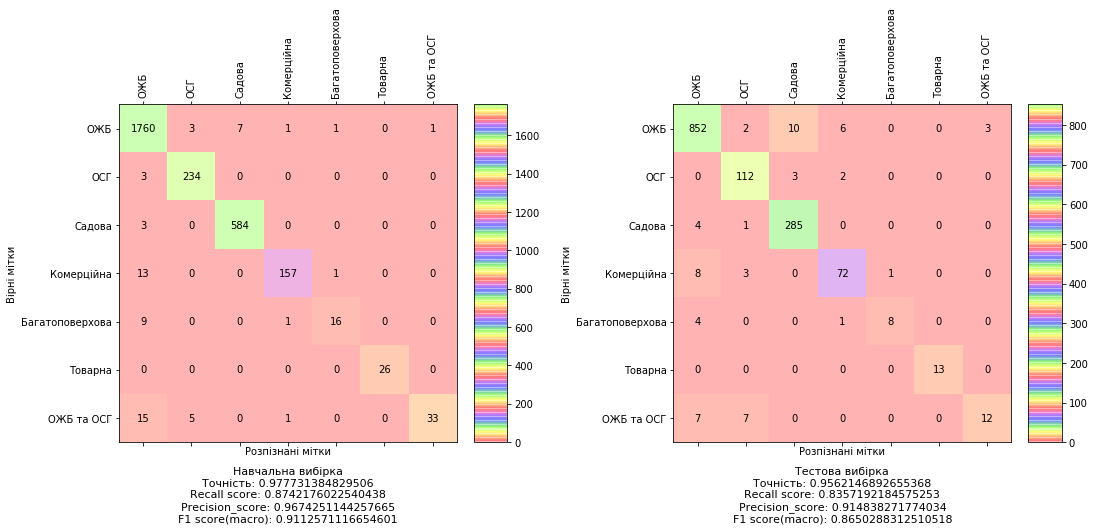

________________________________________________________________________
LinearSVC


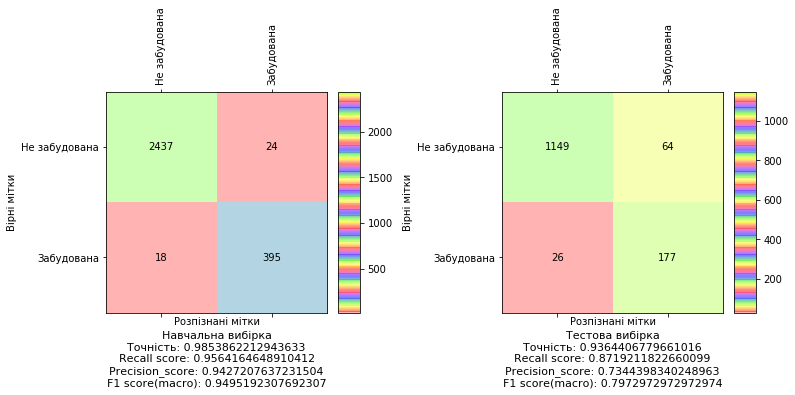

________________________________________________________________________


In [25]:


models_params_best_typy={ 'LinearSVC': [Pipeline([('Vectorizer',None),
                                             ('feature_selection',MySelectFromModel(LinearSVC())),                                            
                                             ('clf',LinearSVC())]),
                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[3.5],
                                        'clf__penalty':['l1'],
                                        'clf__class_weight':[None],
                                         'clf__dual':[False]                                      
                                         }]}
models_params_best_zab={'LinearSVC': [Pipeline([('Vectorizer',None),
                                ('feature_selection',MySelectFromModel(LinearSVC())),
                                ('clf',LinearSVC())]),                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.1],
                                        'clf__loss':['squared_hinge'],
                                        'clf__C':[3.0],
                                        'clf__penalty':['l1'],
                                        'clf__class_weight':[None],
                                         'clf__dual':[False] 
                                        }]}


Best_Classifiers(X_train, X_test, y_train, y_test,
                         models_params=models_params_best_typy,expl_lables=land_types)


Best_Classifiers(X_train_zab, X_test_zab, y_train_zab, y_test_zab,
                         models_params=models_params_best_zab,expl_lables=built_up)



Приклад використатння класу VotingClassifier()

VotingClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


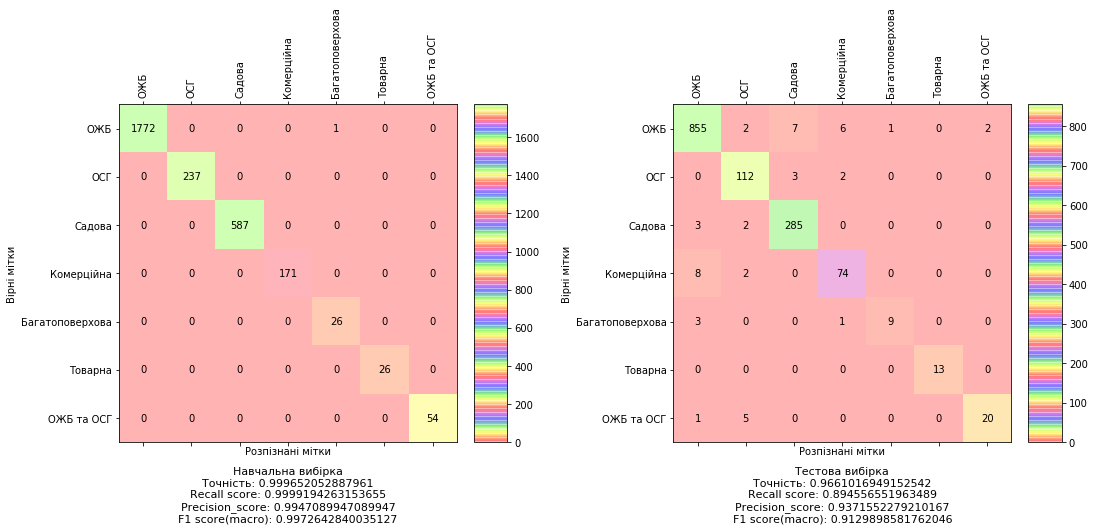

________________________________________________________________________
VotingClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


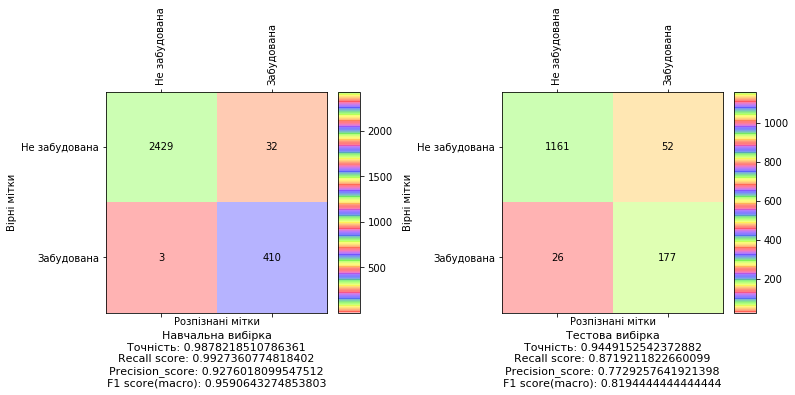

________________________________________________________________________


In [26]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
models_params_best_typy={
         'RandomForestClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                             ('clf',RandomForestClassifier())]),
                                      
                                      {'Vectorizer':[CountVectorizer()],
                                        'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                         'clf__max_depth':[48],
                                         'clf__min_impurity_decrease':[0.0003],
                                         'clf__n_estimators':[250],  
                                         'clf__class_weight':['balanced_subsample'],
                                         'clf__bootstrap':[False],
                                        }],
          
           'LinearSVC': [Pipeline([('Vectorizer',None),
                                             ('feature_selection',MySelectFromModel(LinearSVC())),                                            
                                             ('clf',CalibratedClassifierCV(LinearSVC()))]),
                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                        'clf__base_estimator__loss':['squared_hinge'],
                                        'clf__base_estimator__C':[3.5],
                                        'clf__base_estimator__penalty':['l1'],
                                        'clf__base_estimator__class_weight':[None],
                                         'clf__base_estimator__dual':[False]                                      
                                         }],    
          'LogisticRegression': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',LogisticRegression())]),
                                      {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.00001],
                                                                               
                                         'clf__solver':['liblinear'],
                                         'clf__C':[75],
                                         'clf__penalty':['l1'],
                                         'clf__class_weight':['balanced'],
                                        }
                                      ],        
                   
          'BaggingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',BaggingClassifier())]),
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.0006],
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],                                         
                                         'clf__max_features':[0.75],   
                                        }],
  
    
      
    
    
    
    
}




estimators_typy=dict_to_models(models_params_best_typy)
VotingClassifier_params_typy={
    'VotingClassifier':[VotingClassifier(estimators=estimators_typy),
                        {'voting':['soft'],
                         'weights':[(1, 1, 1, 1)]}]
} 


Best_Classifiers(X_train, X_test, y_train, y_test,
                         models_params=VotingClassifier_params_typy,expl_lables=land_types,
                         savefig_dir='C:/Users/User/Documents/article/Рис 15_1.png')

models_params_best_zab={    
         
    
        'ExtraTreesClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                              ('feature_selection',MySelectFromModel(LinearSVC())),
                                              ('clf',ExtraTreesClassifier())]),
                                      
                                      { 'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],                                        
                                        'feature_selection__threshold':[0.4],                                       
                                         'clf__max_depth':[33],
                                         'clf__min_impurity_decrease':[0.000001],
                                         'clf__n_estimators':[1000],                                         
                                         'clf__bootstrap':[False],
                                        }],
    
        'LogisticRegression': [Pipeline([('Vectorizer',CountVectorizer()),
                                         ('feature_selection',MySelectFromModel(LinearSVC())),
                                         ('pca',KernelPCA()),
                                         ('clf',LogisticRegression())]),
                                      
                                      {'Vectorizer__ngram_range':[(1,1)], 
                                        'feature_selection__threshold':[0.5],                                       
                                         'clf__solver':['saga'],
                                         'clf__C':[100.0],
                                         'clf__penalty':['elasticnet'],                                         
                                         'clf__l1_ratio':[0.5],
                                         'clf__class_weight':[None],
                                        }],

                                       
        
        'LinearSVC': [Pipeline([('Vectorizer',None),
                                ('feature_selection',MySelectFromModel(LinearSVC())),
                                ('clf',CalibratedClassifierCV(LinearSVC()))]),                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.1],
                                        'clf__base_estimator__loss':['squared_hinge'],
                                        'clf__base_estimator__C':[3.0],
                                        'clf__base_estimator__penalty':['l1'],
                                        'clf__base_estimator__class_weight':[None],
                                         'clf__base_estimator__dual':[False] 
                                        }],
           
      
        'BalancedBaggingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                        ('feature_selection',MySelectFromModel(LinearSVC())),
                                        ('clf',BalancedBaggingClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'feature_selection__threshold':[0.1],                                       
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],                                         
                                         'clf__max_features':[0.75],
                                       'clf__sampling_strategy':[0.5], 
                                        }],}


estimators_zab=dict_to_models(models_params_best_zab)
VotingClassifier_params_typy={
    'VotingClassifier':[VotingClassifier(estimators=estimators_zab),
                        {'voting':['soft'],
                         'weights':[(1, 2, 3,4)]}]
} 


Best_Classifiers(X_train_zab, X_test_zab, y_train_zab, y_test_zab,
                         models_params=VotingClassifier_params_typy,expl_lables=built_up,
                         savefig_dir='C:/Users/User/Documents/article/Рис 15_2.png')



Приклад використатння класу StackingClassifier()

StackingClassifier


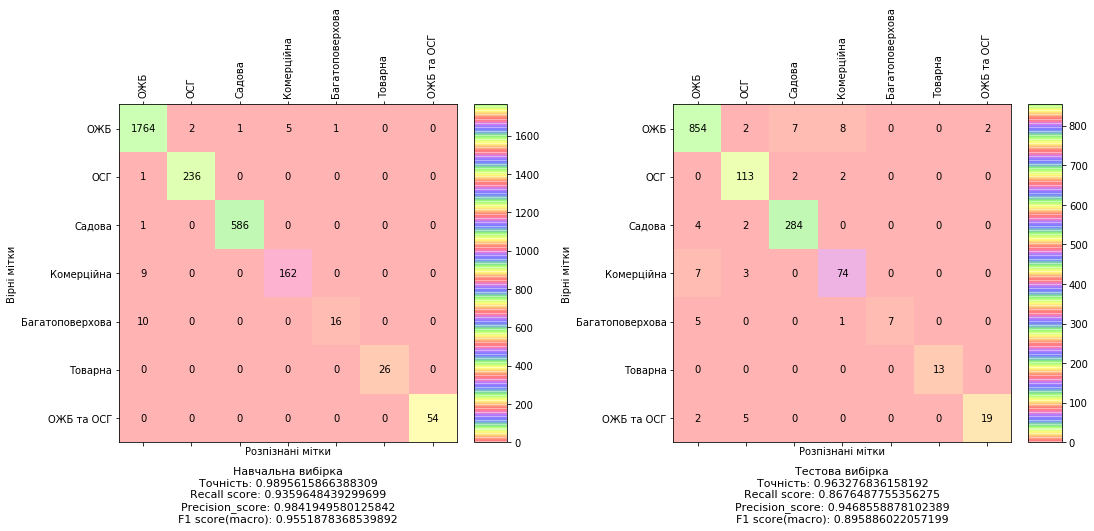

________________________________________________________________________
StackingClassifier


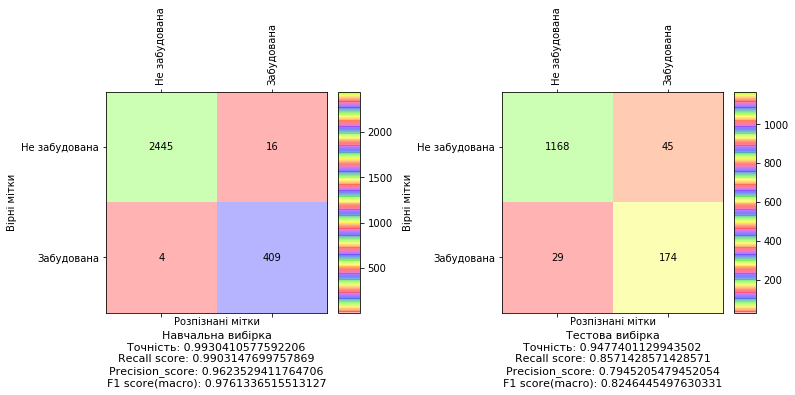

________________________________________________________________________


In [31]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
models_params_best_typy={
         'RandomForestClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                             ('clf',RandomForestClassifier())]),
                                      
                                      {'Vectorizer':[CountVectorizer()],
                                        'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                         'clf__max_depth':[48],
                                         'clf__min_impurity_decrease':[0.0003],
                                         'clf__n_estimators':[250],  
                                         'clf__class_weight':['balanced_subsample'],
                                         'clf__bootstrap':[False],
                                        }],
          
           'LinearSVC': [Pipeline([('Vectorizer',None),
                                             ('feature_selection',MySelectFromModel(LinearSVC())),                                            
                                             ('clf',CalibratedClassifierCV(LinearSVC()))]),
                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.5],
                                        'clf__base_estimator__loss':['squared_hinge'],
                                        'clf__base_estimator__C':[3.5],
                                        'clf__base_estimator__penalty':['l1'],
                                        'clf__base_estimator__class_weight':[None],
                                         'clf__base_estimator__dual':[False]                                      
                                         }],    
          'LogisticRegression': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',LogisticRegression())]),
                                      {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.00001],
                                                                               
                                         'clf__solver':['liblinear'],
                                         'clf__C':[75],
                                         'clf__penalty':['l1'],
                                         'clf__class_weight':['balanced'],
                                        }
                                      ],        
                   
          'BaggingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(ExtraTreesClassifier())),
                                             ('clf',BaggingClassifier())]),
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.0006],
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],                                         
                                         'clf__max_features':[0.75],   
                                        }],
  
    
      
    
    
    
    
}







estimators_typy=dict_to_models(models_params_best_typy)
StackingClassifier_params_typy={
    'StackingClassifier':[StackingClassifier(estimators=estimators_typy),
                        {'n_jobs':[-1],
                         'final_estimator':[LinearSVC()]}]
} 


Best_Classifiers(X_train, X_test, y_train, y_test,
                         models_params=StackingClassifier_params_typy,expl_lables=land_types)

models_params_best_zab_VotingClassifier={    
           'ExtraTreesClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                              ('feature_selection',MySelectFromModel(LinearSVC())),
                                              ('clf',ExtraTreesClassifier())]),
                                      
                                      { 'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],                                        
                                        'feature_selection__threshold':[0.4],                                       
                                         'clf__max_depth':[33],
                                         'clf__min_impurity_decrease':[0.000001],
                                         'clf__n_estimators':[1000],                                         
                                         'clf__bootstrap':[False],
                                        }],
    
        'LogisticRegression': [Pipeline([('Vectorizer',CountVectorizer()),
                                         ('feature_selection',MySelectFromModel(LinearSVC())),
                                         ('pca',KernelPCA()),
                                         ('clf',LogisticRegression())]),
                                      
                                      {'Vectorizer__ngram_range':[(1,1)], 
                                        'feature_selection__threshold':[0.5],                                       
                                         'clf__solver':['saga'],
                                         'clf__C':[100.0],
                                         'clf__penalty':['elasticnet'],                                         
                                         'clf__l1_ratio':[0.5],
                                         'clf__class_weight':[None],
                                        }],

                                       
        
        'LinearSVC': [Pipeline([('Vectorizer',None),
                                ('feature_selection',MySelectFromModel(LinearSVC())),
                                ('clf',CalibratedClassifierCV(LinearSVC()))]),                                       
                                       {'Vectorizer':[TfidfVectorizer()],
                                        'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.1],
                                        'clf__base_estimator__loss':['squared_hinge'],
                                        'clf__base_estimator__C':[3.0],
                                        'clf__base_estimator__penalty':['l1'],
                                        'clf__base_estimator__class_weight':[None],
                                         'clf__base_estimator__dual':[False] 
                                        }],
           
      
        'BalancedBaggingClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                        ('feature_selection',MySelectFromModel(LinearSVC())),
                                        ('clf',BalancedBaggingClassifier())]),                                      
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'feature_selection__threshold':[0.1],                                       
                                         'clf__base_estimator':[None],
                                         'clf__bootstrap_features':[False],
                                         'clf__n_estimators':[500],
                                         'clf__warm_start':[True],
                                         'clf__bootstrap':[False],                                         
                                         'clf__max_features':[0.75],
                                       'clf__sampling_strategy':[0.5], 
                                        }],}


estimators_zab=dict_to_models(models_params_best_zab_VotingClassifier)
StackingClassifier_params_zab={
    'StackingClassifier':[StackingClassifier(estimators=estimators_zab),
                        {'n_jobs':[-1],
                         'final_estimator':[LinearSVC()]}]
} 

Best_Classifiers(X_train_zab, X_test_zab, y_train_zab, y_test_zab,
                         models_params=StackingClassifier_params_zab,expl_lables=built_up)

Приклад простої нейронної мережі

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


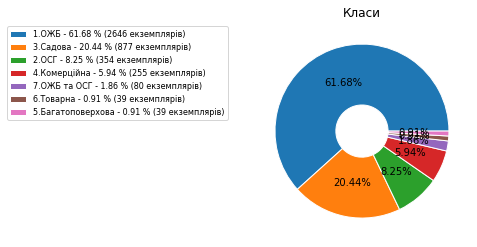

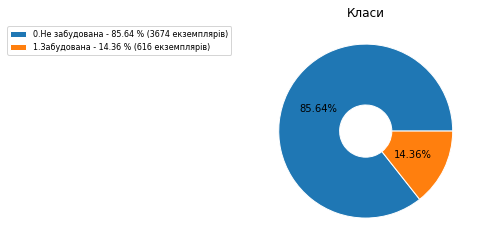

Train on 2874 samples
Epoch 1/5
2874/2874 [==============================] - 3s 899us/sample - loss: 0.7545 - accuracy: 0.6865
Epoch 2/5
2874/2874 [==============================] - 2s 761us/sample - loss: 0.3998 - accuracy: 0.8640
Epoch 3/5
2874/2874 [==============================] - 2s 747us/sample - loss: 0.2390 - accuracy: 0.9360
Epoch 4/5
2874/2874 [==============================] - 2s 773us/sample - loss: 0.1694 - accuracy: 0.9544
Epoch 5/5
2874/2874 [==============================] - 2s 765us/sample - loss: 0.1365 - accuracy: 0.9628
1416/1416 - 0s - loss: 0.1840 - accuracy: 0.9379
test loss: 0.1839504521445366, test acc: 0.9378530979156494
[[1186   27]
 [  61  142]]
Train on 2874 samples
Epoch 1/5
2874/2874 [==============================] - 3s 882us/sample - loss: 1.1689 - accuracy: 0.6475
Epoch 2/5
2874/2874 [==============================] - 2s 752us/sample - loss: 0.5207 - accuracy: 0.8657
Epoch 3/5
2874/2874 [==============================] - 2s 750us/sample - loss: 0.3466

In [45]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer

def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)

  
def first_model(n_classes): 
    model = tf.keras.models.Sequential([

      tf.keras.layers.Dense(2000, activation='relu'),
      tf.keras.layers.BatchNormalization(),   
      tf.keras.layers.Dropout(0.50),      
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.BatchNormalization(),  
      tf.keras.layers.Dropout(0.50),  
      tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def fit_print (X_train, X_test, y_train, y_test,n_classes):
    t = Tokenizer(num_words=2000)
    t.fit_on_texts(X_train)

    X_train = t.texts_to_matrix(X_train, mode='count')
    X_test = t.texts_to_matrix(X_test, mode='count')


    model=first_model(n_classes)
    model.fit(X_train, y_train, epochs=5)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print ('test loss: {0}, test acc: {1}'.format(results[0],results[1]))
    y_pred=model.predict_classes(X_test)   
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    print(con_mat.numpy())

fit_print (X_train_zab, X_test_zab,np.array(y_train_zab), np.array(y_test_zab),2) 
fit_print (X_train, X_test, np.array(y_train)-1, np.array(y_test)-1,7)   




Реалізація решіткового пошуку для підбору гіперпараметрів нейронної мережі

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


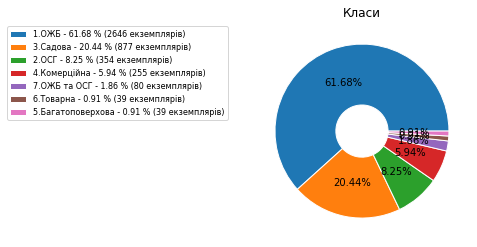

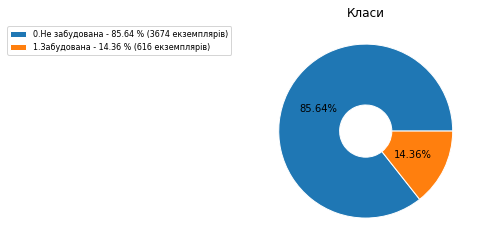

Running GridSearchCV for KerasClassifier.
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 25.1min finished


KerasClassifier
          estimator min_score mean_score max_score   std_score  \
0   KerasClassifier  0.751781  0.784181   0.81322   0.0251946    
1   KerasClassifier  0.744877  0.775868   0.805174  0.0246447    
2   KerasClassifier  0.710343  0.766376   0.816841  0.0436556    
3   KerasClassifier  0.744937  0.765909   0.805421  0.0279567    
4   KerasClassifier  0.724707  0.757716   0.815381  0.040918     
5   KerasClassifier  0.725047  0.7574     0.796536  0.0295769    
6   KerasClassifier  0.720952  0.751034   0.794083  0.0312323    
7   KerasClassifier  0.697977  0.745396   0.80249   0.043212     
8   KerasClassifier  0.69944   0.741359   0.789182  0.0368742    
9   KerasClassifier  0.714817  0.739919   0.786089  0.0326885    
10  KerasClassifier  0.719507  0.73246    0.754636  0.0157549    
11  KerasClassifier  0.706758  0.729838   0.750157  0.0178251    
12  KerasClassifier  0.711583  0.728566   0.752056  0.0171514    
13  KerasClassifier  0.664958  0.727059   0.798433  0.054884

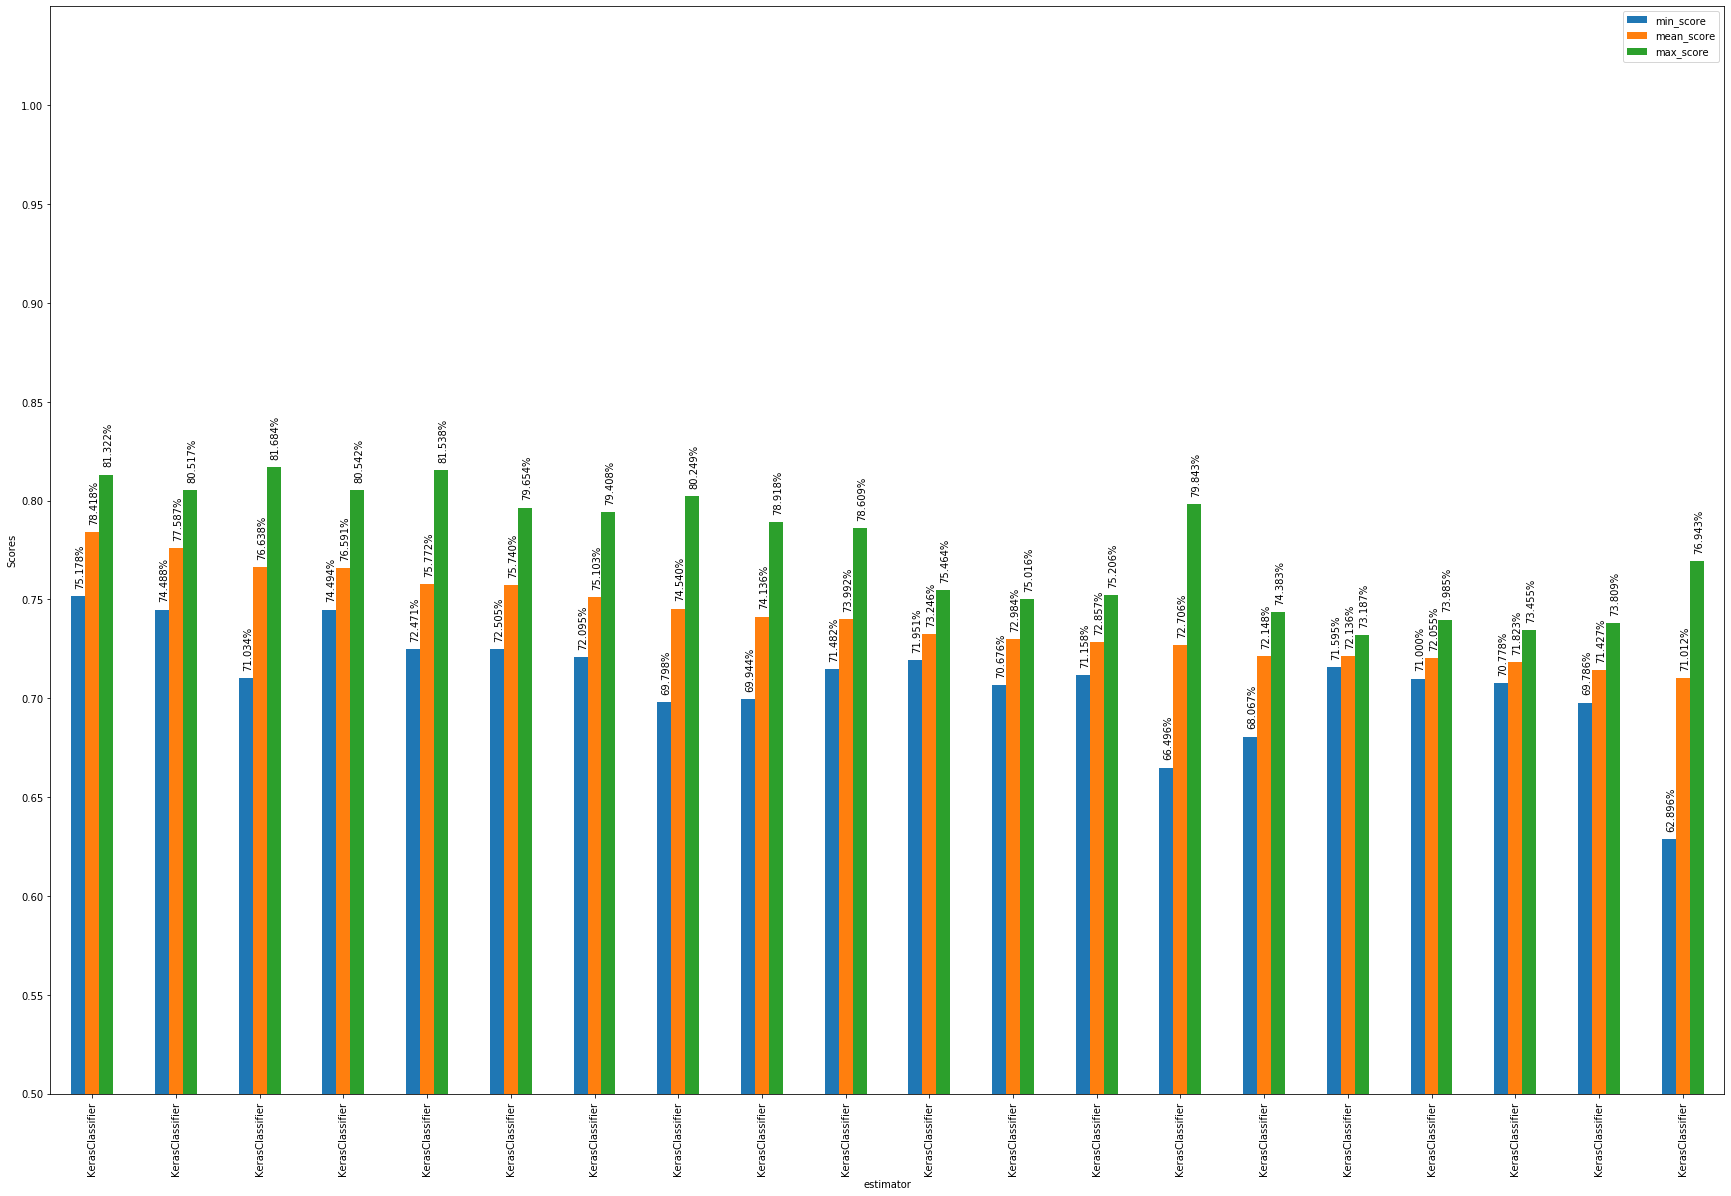

________________________________________________________________________
Running GridSearchCV for KerasClassifier.
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 12.3min finished


KerasClassifier
          estimator min_score mean_score max_score   std_score  \
0   KerasClassifier  0.786047  0.809944   0.848459  0.0274964    
1   KerasClassifier  0.794324  0.806344   0.81777   0.00958106   
2   KerasClassifier  0.754359  0.786682   0.82812   0.0307948    
3   KerasClassifier  0.727261  0.783382   0.821584  0.0405384    
4   KerasClassifier  0.775234  0.783115   0.797421  0.0101335    
5   KerasClassifier  0.757799  0.782705   0.816258  0.0246368    
6   KerasClassifier  0.731182  0.768817   0.825905  0.0410437    
7   KerasClassifier  0.737945  0.76388    0.78411   0.0192738    
8   KerasClassifier  0.707106  0.737414   0.774697  0.0280313    
9   KerasClassifier  0.646979  0.737221   0.856841  0.0881584    
10  KerasClassifier  0.67173   0.732381   0.764402  0.042909     
11  KerasClassifier  0.702281  0.729037   0.751145  0.0202176    
12  KerasClassifier  0.679685  0.725217   0.772663  0.0379819    
13  KerasClassifier  0.714724  0.720753   0.729588  0.006384

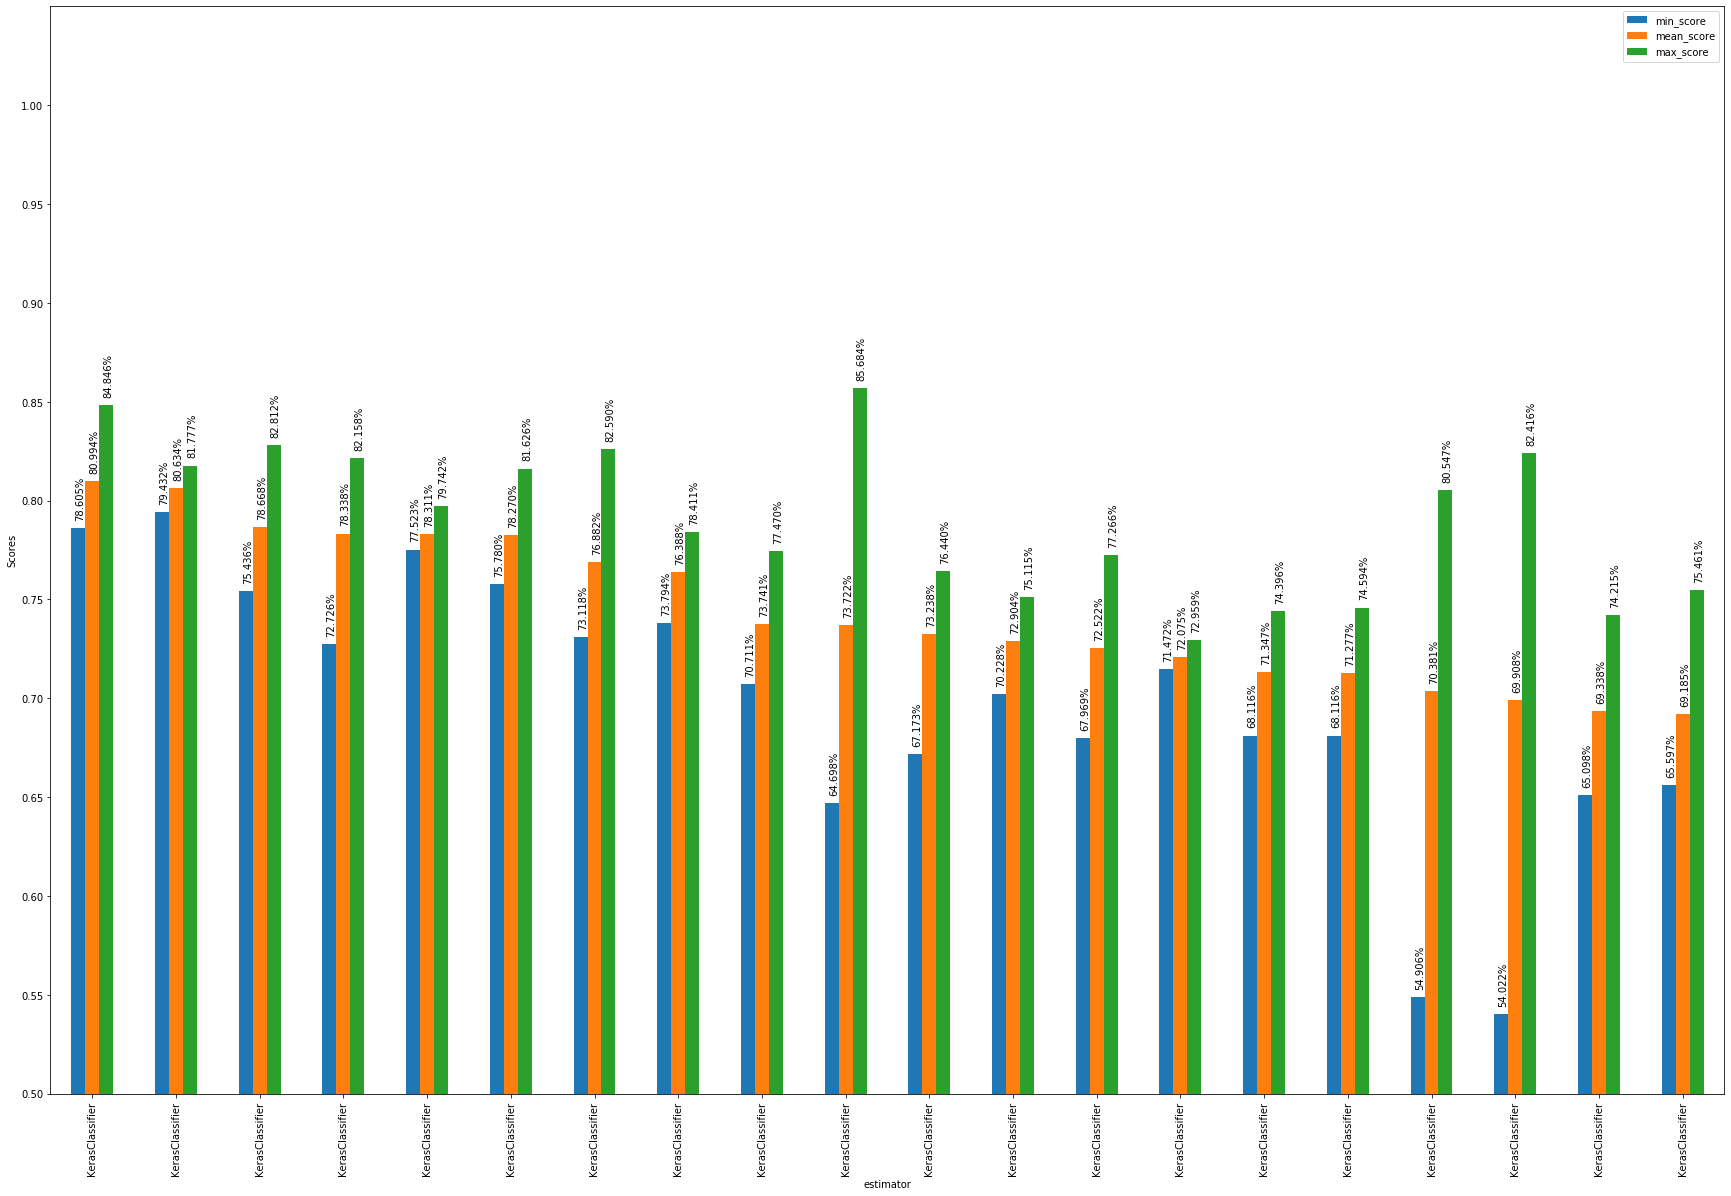

________________________________________________________________________


In [34]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer

def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import TransformerMixin
def skl_model(units=2000,n_classes=10,n_layers=1,Dropout=0.5): 
    model = tf.keras.Sequential()
    
    model = tf.keras.models.Sequential()
    for n in range(1,n_layers+1):
        model.add(tf.keras.layers.Dense(units/n, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(Dropout))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

class ToarrayTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train_zab=np.array(y_train_zab)
y_test_zab=np.array(y_test_zab)
models_params_typy={
        'KerasClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                       'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                      'feature_selection__threshold':[0.2,0.1,0.5],
                                         'clf__units':[1000,500],
                                        'clf__n_classes':[7],                                         
                                         'clf__n_layers':[3,2],
                                         'clf__Dropout':[0.5,0.4],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}

  
GridSearchCV_Classifiers(X=X_train, y=y_train-1,
                         models_params=models_params_typy,scoring='f1_macro',cv=3)


models_params_zab={
        'KerasClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                       'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.2,0.1,0.5],
                                         'clf__units':[1000,500],
                                        'clf__n_classes':[2],                                         
                                         'clf__n_layers':[3,2],
                                         'clf__Dropout':[0.5,0.4],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}


GridSearchCV_Classifiers(X=X_train_zab, y=y_train_zab,
                         models_params=models_params_zab,scoring='f1_macro',cv=3)

Нейронна мережа із підібраними гіперпараметрами

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


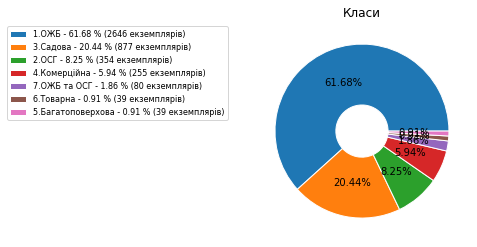

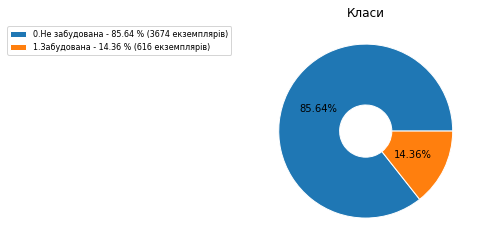

KerasClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


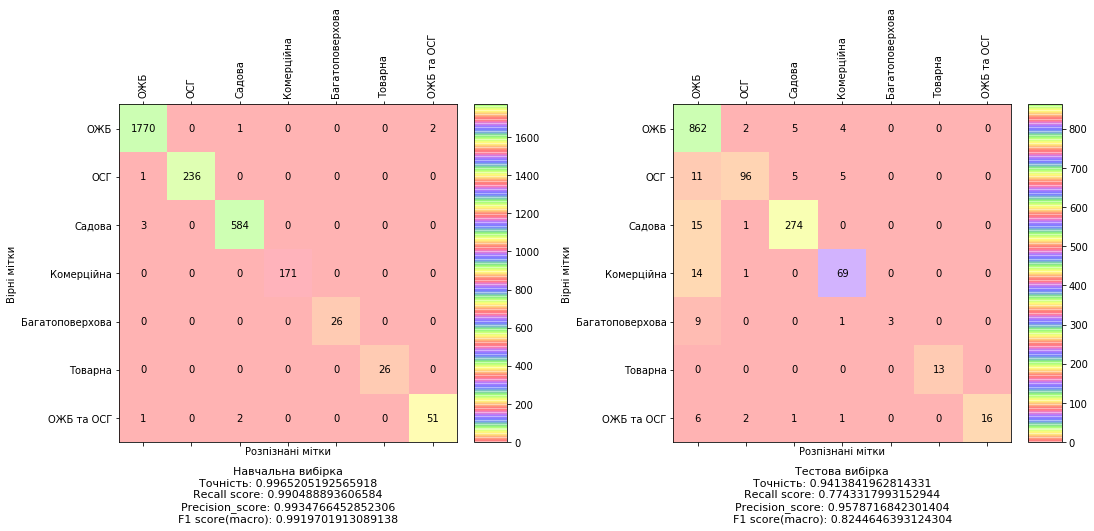

________________________________________________________________________
KerasClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


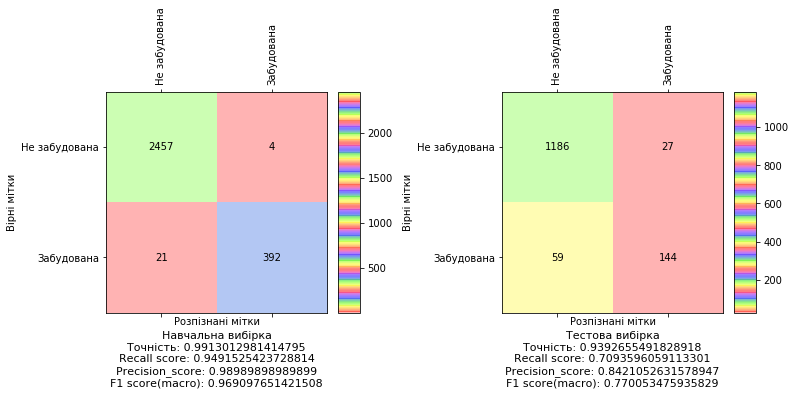

________________________________________________________________________


In [32]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer

def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import TransformerMixin
def skl_model(units=2000,n_classes=10,n_layers=1,Dropout=0.5): 
    model = tf.keras.Sequential()
    
    model = tf.keras.models.Sequential()
    for n in range(1,n_layers+1):
        model.add(tf.keras.layers.Dense(units/n, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(Dropout))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

class ToarrayTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train_zab=np.array(y_train_zab)
y_test_zab=np.array(y_test_zab)
models_params_typy={
        'KerasClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                      'feature_selection__threshold':[0.1],
                                         'clf__units':[1000],
                                        'clf__n_classes':[7],                                         
                                         'clf__n_layers':[2],
                                         'clf__Dropout':[0.4],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}

  
Best_Classifiers(X_train, X_test, y_train, y_test,
                         models_params=models_params_typy,expl_lables=land_types)


models_params_zab={
        'KerasClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.2,0.1,0.5],
                                         'clf__units':[500],
                                        'clf__n_classes':[2],                                         
                                         'clf__n_layers':[2],
                                         'clf__Dropout':[0.5],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}


Best_Classifiers(X_train_zab, X_test_zab, y_train_zab, y_test_zab,
                         models_params=models_params_zab,expl_lables=built_up)


Приклад згорткової нейронної мережі

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


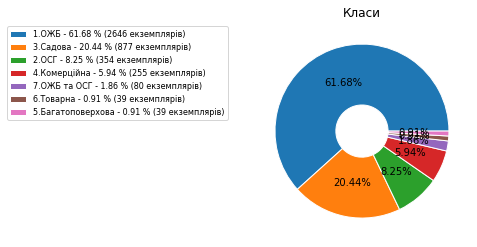

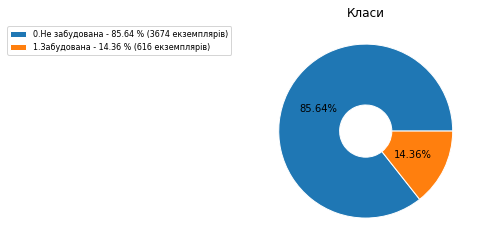

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/6
2586/2586 [==============================] - 19s 7ms/sample - loss: 0.4397 - accuracy: 0.8507 - val_loss: 0.4043 - val_accuracy: 0.8576
Epoch 2/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.3838 - accuracy: 0.8561 - val_loss: 0.3796 - val_accuracy: 0.8576
Epoch 3/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.3161 - accuracy: 0.8573 - val_loss: 0.2941 - val_accuracy: 0.8889
Epoch 4/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.1725 - accuracy: 0.9323 - val_loss: 0.2726 - val_accuracy: 0.9028
Epoch 5/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.0872 - accuracy: 0.9667 - val_loss: 0.2384 - val_accuracy: 0.9375
Epoch 6/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.0474 - accuracy: 0.9841 - val_loss: 0.2584 -

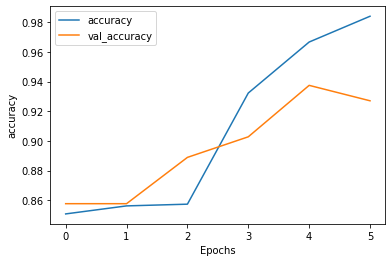

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 1.2079 - accuracy: 0.6137 - val_loss: 0.8845 - val_accuracy: 0.6354
Epoch 2/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.7574 - accuracy: 0.7413 - val_loss: 0.6217 - val_accuracy: 0.8056
Epoch 3/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.5441 - accuracy: 0.8357 - val_loss: 0.4404 - val_accuracy: 0.8611
Epoch 4/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.3048 - accuracy: 0.9053 - val_loss: 0.2792 - val_accuracy: 0.9271
Epoch 5/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.2171 - accuracy: 0.9370 - val_loss: 0.3143 - val_accuracy: 0.9306
Epoch 6/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.1319 - accuracy: 0.9656 - val_loss: 0.2900 -

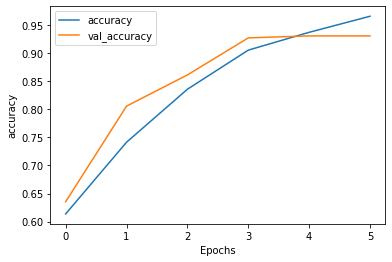

In [28]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.datasets import imdb
    
def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)


import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()



def fit_print_conv(X_train, X_test, y_train, y_test,n_classes): 

    # set parameters:
    max_features = 5000
    maxlen = 400
    batch_size = 32
    embedding_dims = 150
    filters = 500
    kernel_size = 3
    hidden_dims = 250
    epochs = 6
    
    
    t = Tokenizer(num_words=max_features)
    t.fit_on_texts(X_train)    
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)

    
    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    
    X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.10,random_state=42)

    
    print('Build model...')
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters//10,
                     kernel_size,
                     padding='same',
                     activation='relu'))
    model.add(Dropout(0.1))
   
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(n_classes))
    model.add(Activation('sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val))
    
    results = model.evaluate(X_test,  y_test, verbose=2)
    print ('test loss: {0}, test acc: {1}'.format(results[0],results[1]))
    y_pred=model.predict_classes(X_test)   
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    print(con_mat.numpy())
    plot_graphs(history, 'accuracy')
    


    
    
fit_print_conv (X_train_zab, X_test_zab,np.array(y_train_zab), np.array(y_test_zab),2) 
fit_print_conv (X_train, X_test, np.array(y_train)-1, np.array(y_test)-1,7)   




Приклад рекорентної нейронної мережі

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


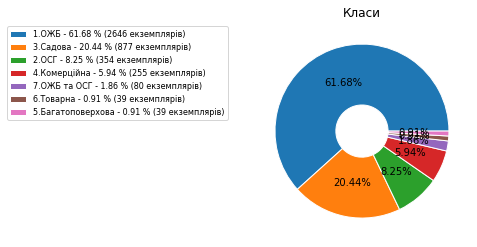

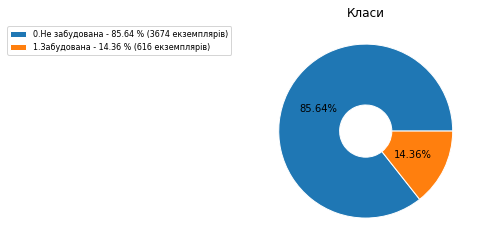

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/5
2586/2586 [==============================] - 23s 9ms/sample - loss: 0.4063 - accuracy: 0.8554 - val_loss: 0.2804 - val_accuracy: 0.8750
Epoch 2/5
2586/2586 [==============================] - 21s 8ms/sample - loss: 0.1925 - accuracy: 0.9346 - val_loss: 0.1886 - val_accuracy: 0.9340
Epoch 3/5
2586/2586 [==============================] - 21s 8ms/sample - loss: 0.1254 - accuracy: 0.9578 - val_loss: 0.2104 - val_accuracy: 0.9410
Epoch 4/5
2586/2586 [==============================] - 20s 8ms/sample - loss: 0.0962 - accuracy: 0.9702 - val_loss: 0.2094 - val_accuracy: 0.9375
Epoch 5/5
2586/2586 [==============================] - 21s 8ms/sample - loss: 0.0774 - accuracy: 0.9756 - val_loss: 0.2415 - val_accuracy: 0.9375
1416/1416 - 4s - loss: 0.2227 - accuracy: 0.9216
test loss: 0.22268142285993545, test acc: 0.9216101765632629
[[1140   73]
 

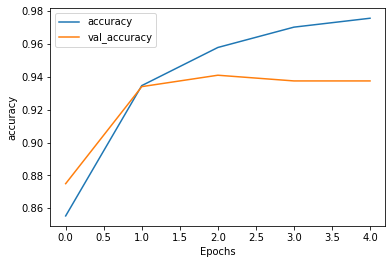

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/10
2586/2586 [==============================] - 86s 33ms/sample - loss: 1.2277 - accuracy: 0.6110 - val_loss: 1.1450 - val_accuracy: 0.6181
Epoch 2/10
2586/2586 [==============================] - 106s 41ms/sample - loss: 1.0476 - accuracy: 0.6168 - val_loss: 0.8251 - val_accuracy: 0.6181
Epoch 3/10
2586/2586 [==============================] - 110s 43ms/sample - loss: 0.6757 - accuracy: 0.7529 - val_loss: 0.4695 - val_accuracy: 0.8785
Epoch 4/10
2586/2586 [==============================] - 118s 46ms/sample - loss: 0.4336 - accuracy: 0.8991 - val_loss: 0.4223 - val_accuracy: 0.8958
Epoch 5/10
2586/2586 [==============================] - 114s 44ms/sample - loss: 0.3498 - accuracy: 0.9161 - val_loss: 0.3916 - val_accuracy: 0.8889
Epoch 6/10
2586/2586 [==============================] - 112s 43ms/sample - loss: 0.2891 - accuracy: 0.9234 - v

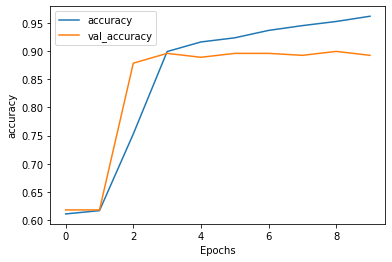

In [29]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.datasets import imdb
    
def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)
 

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()



def fit_print_rnn(X_train, X_test, y_train, y_test,n_classes,units,epochs): 

    # set parameters:
    max_features = 5000
    maxlen = 400
    batch_size = 32
    embedding_dims = 100
    kernel_size = 3
    hidden_dims = 250    
    
    
    t = Tokenizer(num_words=max_features)
    t.fit_on_texts(X_train)    
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)

    
    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    
    X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.10,random_state=42)

    
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features,
                        embedding_dims, 
                        input_length=maxlen
                       ))
    model.add(Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(units,  return_sequences=True, dropout=0.4))
    model.add(tf.keras.layers.LSTM(units//2,  dropout=0.4))
    model.add(Dense(n_classes, activation='sigmoid'))


    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val))
    results = model.evaluate(X_test,  y_test, verbose=2)
    print ('test loss: {0}, test acc: {1}'.format(results[0],results[1]))
    y_pred=model.predict_classes(X_test)   
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    print(con_mat.numpy())
    plot_graphs(history, 'accuracy')
    


    
    




fit_print_rnn (X_train_zab, X_test_zab,np.array(y_train_zab), np.array(y_test_zab),2,64,5) 
fit_print_rnn (X_train, X_test, np.array(y_train)-1, np.array(y_test)-1,7,196,10) 

Приклад побудови моделі word2vec

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


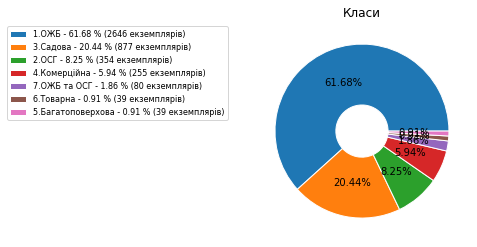

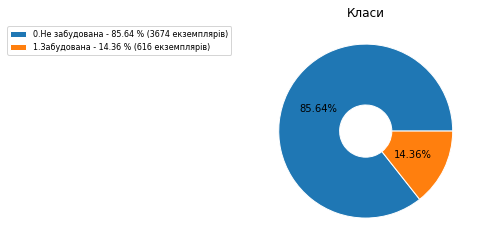

Word2Vec
Слово 'ділянка' -  [('мрію', 0.12444563210010529), ('присвоєний', 0.1221877932548523), ('горы', 0.1125452071428299), ('господарства', 0.10289157181978226), ('неї', 0.10067432373762131), ('пилипец', 0.10029172897338867), ('зовсім', 0.09704037010669708), ('потічок', 0.09689418971538544), ('широка', 0.09640874713659286), ('проходить', 0.09575922787189484)]
Слово 'земельна' -  [('увазі', 0.1161714568734169), ('хуст', 0.10643313825130463), ('зведення', 0.10264638066291809), ('початкова', 0.1005157008767128), ('зведено', 0.09715737402439117), ('гакадастровий', 0.095176562666893), ('тзов', 0.09422482550144196), ('колії', 0.09348714351654053), ('суховолі', 0.09305611252784729), ('електричка', 0.09153789281845093)]
Слово 'будинка' -  [('різного', 0.11177098006010056), ('садочка', 0.10531207919120789), ('приватизований', 0.10071966052055359), ('облаштування', 0.0977017879486084), ('станция', 0.09768658876419067), ('плай', 0.09451328217983246), ('жилыми', 0.08689279854297638), ('спарку',

In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.datasets import imdb

from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import scale

    
def ua_tokenizer(text,ua_stemmer=True,stop_words=[]):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    ua_stemmer -- if True use UkrainianStemmer for stemming words (default True)
    stop_words -- list of stop words (default [])
        
    """
    tokenized_list=[]
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    for word in nltk.word_tokenize(text): 
        if word.isalpha():
            word=word.lower() 
            if ua_stemmer is True:      
                word=UkrainianStemmer(word).stem_word()
            if word not in stop_words:
                tokenized_list.append(word) 
    return tokenized_list
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['opys']+' '+land_data['typ_diljanky']+' '+land_data['ciljove_pryznach_zgidno_pkku']
def land_typ():    
    data=pd.read_csv('land_types.csv')
    data=data[['id_typu_diljanky','korotka_nazva_typy_diljanky']]
    data=data.set_index('id_typu_diljanky')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_typ()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','typy','zabudovana'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'typy':6,'zabudovana':0}, ignore_index=True)
    return df.astype({'text':'object','typy': 'int32','zabudovana': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='typy',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='zabudovana',expl_lables=built_up)
X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['zabudovana'],
                                                                  stratify=land_data['zabudovana'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['typy'],
                                                  stratify=land_data['typy'],
                                                  test_size=0.33,random_state=0)

 
def dataset_to_Word2Vec(X,model_dir='word2vec_gensim.bin',ua_stemmer=False):
    print('Word2Vec')
    try:
        model = Word2Vec.load(model_dir)
    except IOError:
        X=X.map(lambda x: ua_tokenizer(x,ua_stemmer=ua_stemmer))
        model = Word2Vec(X, size=1000, min_count=10, workers=-1)        
        model.train(X, total_examples=model.corpus_count, epochs=10000)
        model.init_sims(replace=True)
        model.save(model_dir)
    finally:
        return model

model = dataset_to_Word2Vec(land_data['text'],model_dir='word2vec_gensim_all_corpus.bin')

print ("Слово 'ділянка' - ", model.wv.most_similar('ділянка'))
print ("Слово 'земельна' - ",model.wv.most_similar('земельна'))  
print ("Слово 'будинка' - ",model.wv.most_similar('будинка'))  


